# Ames housing dataset modelling challenge

## Introduction

As part of a Kaggle challenge, we were given housing datasets, `train.csv` and `test.csv`, and were asked to develop a model that can accurately predict the `SalePrice` column of the testing set, which was not given [1]. We were asked to optimize the RMSE, meaning to optimize our predictions in terms of dollars.

## Preparations

In [1]:
import numpy as np
import pandas as pd
from skimpy import skim
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer, FunctionTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
housing_train = pd.read_csv("../data/train.csv", index_col=["Id"])

In [3]:
housing_test = pd.read_csv("../data/test.csv", index_col=["Id"])

In [4]:
housing_train

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1612         532  526352080           20        RL          85.0     10667   
2045         415  904100100           70        RL         107.0     12888   
1962         273  535451110           20        RL          60.0      7200   
229         1460  905109130           60        RL          80.0     14000   
1105         250  528363020           60        RL           NaN     11929   
...          ...        ...          ...       ...           ...       ...   
1705        1724  528142050           60        RL          82.0      9709   
1242        1095  535178060           20        RL          72.0      9000   
2358        1130  527377030           20        RL          78.0     10140   
1043        1294  527451060          160        RM          21.0      1869   
2774         860  907175030           20        RL          70.0      9100   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1612   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2045   Pave   NaN       Reg          Bnk  ...            0         0     NaN   
1962   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
229    Pave   NaN       Reg          Lvl  ...            0         0     NaN   
1105   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
1705   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
1242   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2358   Pave   NaN       Reg          Lvl  ...            0       648      Fa   
1043   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2774   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1612    NaN          NaN        0       3    2007        WD      167300  
2045    NaN          NaN        0       4    2007        WD      219000  
1962    NaN          NaN        0       7    2007        WD      129000  
229     NaN          NaN        0       4    2010        WD      328000  
1105    NaN          NaN        0       6    2008        WD      290000  
...     ...          ...      ...     ...     ...        ...        ...  
1705    NaN          NaN        0       9    2007        New     319500  
1242    NaN          NaN        0       5    2008        WD      139000  
2358  GdPrv          NaN        0       1    2006        WD      181000  
1043    NaN          NaN        0       9    2008        WD      106000  
2774    NaN          NaN        0       9    2006        WD      235000  

[1538 rows x 81 columns]

In [5]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1538 entries, 1612 to 2774
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1538 non-null   int64  
 1   PID              1538 non-null   int64  
 2   MS SubClass      1538 non-null   int64  
 3   MS Zoning        1538 non-null   object 
 4   Lot Frontage     1285 non-null   float64
 5   Lot Area         1538 non-null   int64  
 6   Street           1538 non-null   object 
 7   Alley            111 non-null    object 
 8   Lot Shape        1538 non-null   object 
 9   Land Contour     1538 non-null   object 
 10  Utilities        1538 non-null   object 
 11  Lot Config       1538 non-null   object 
 12  Land Slope       1538 non-null   object 
 13  Neighborhood     1538 non-null   object 
 14  Condition 1      1538 non-null   object 
 15  Condition 2      1538 non-null   object 
 16  Bldg Type        1538 non-null   object 
 17  House Style     

## Cleaning and exploratory data analysis

### Note

As part of the cleaning process, we will be transforming categorical columns. The lack of nominal values--like the lack of a pool--will often be encoded with a category `"0"`, to facilitate their dropping via `OneHotEncoder` objects' `drop="first"` and avoid multicollinearity. `"0"`s will also be used in ordinal encoding to express the lack of a feature and maintain the same style. Throughout this process, we will use column transformers, pipelines, and will later consolidate the entire process into a single pipeline.
<br>
Note that sometimes a column transformer will be the most practical approach to clean a column, but in many cases, due to the order of operations--like first impute, then encode--it will not . To maintain the same style, we will stick to always using pipelines when cleaning columns, even if a standalone column transformer will suffice.
<br>
To start the cleaning, we sort by `Id`. This is just a nitpick.

In [6]:
housing_train.sort_values(inplace=True, by="Id")

### Summary statistics

In [7]:
skim(housing_train.drop(columns=["Unnamed: 0", "PID"]))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1538   │ │ string      │ 42    │                                                          │
│ │ Number of columns │ 79     │ │ int64       │ 26    │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 11    │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ MS SubClass       │    0 │      0 │      57 │     43 │     20 │     20 │     50 │     70 │    190 │ ▇▆▂▁▁▁ │  │
│ │ Lot Frontage      │  253 │  16.45 │      69 │     24 │     21 │     58 │     68 │     80 │    310 │   ▇▇   │  │
│ │ Lot Area          │    0 │      0 │   10000 │   5400 │   1500 │   7500 │   9500 │  11000 │  64000 │   ▇▂   │  │
│ │ Overall Qual      │    0 │      0 │     6.1 │    1.4 │      1 │      5 │      6 │      7 │     10 │   ▇▆▇▁ │  │
│ │ Overall Cond      │    0 │      0 │     5.6 │    1.1 │      1 │      5 │      5 │      6 │      9 │    ▇▁▁ │  │
│ │ Year Built        │    0 │      0 │    2000 │     30 │   1900 │   2000 │   2000 │   2000 │   2000 │  ▁▂▅▅▇ │  │
│ │ Year Remod/Add    │    0 │      0 │    2000 │     21 │   2000 │   2000 │   2000 │   2000 │   2000 │ ▅▂▂▁▃▇ │  │
│ │ Mas Vnr Area      │   18 │   1.17 │      99 │    180 │      0 │      0 │      0 │    160 │   1600 │   ▇▁   │  │
│ │ BsmtFin SF 1      │    1 │   0.07 │     440 │    470 │      0 │      0 │    370 │    740 │   5600 │   ▇▁   │  │
│ │ BsmtFin SF 2      │    1 │   0.07 │      48 │    170 │      0 │      0 │      0 │      0 │   1500 │   ▇    │  │
│ │ Bsmt Unf SF       │    1 │   0.07 │     570 │    440 │      0 │    220 │    470 │    810 │   2300 │ ▇▆▃▁▁  │  │
│ │ Total Bsmt SF     │    1 │   0.07 │    1100 │    450 │      0 │    790 │    990 │   1300 │   6100 │   ▇▇   │  │
│ │ 1st Flr SF        │    0 │      0 │    1200 │    400 │    330 │    870 │   1100 │   1400 │   5100 │   ▇▆   │  │
│ │ 2nd Flr SF        │    0 │      0 │     330 │    430 │      0 │      0 │      0 │    690 │   1900 │  ▇▂▃▁  │  │
│ │ Low Qual Fin SF   │    0 │      0 │     5.6 │     53 │      0 │      0 │      0 │      0 │   1100 │   ▇    │  │
│ │ Gr Liv Area       │    0 │      0 │    1500 │    510 │    330 │   1100 │   1400 │   1700 │   5600 │  ▅▇▁   │  │
│ │ Bsmt Full Bath    │    2 │   0.13 │    0.43 │   0.53 │      0 │      0 │      0 │      1 │      3 │  ▇ ▅   │  │
│ │ Bsmt Half Bath    │    2 │   0.13 │   0.061 │   0.25 │      0 │      0 │      0 │      0 │      2 │   ▇    │  │
│ │ Full Bath         │    0 │      0 │     1.6 │   0.55 │      0 │      1 │      2 │      2 │      4 │   ▇ ▇  │  │
│ │ Half Bath         │    0 │      0 │    0.38 │    0.5 │      0 │      0 │      0 │      1 │      2 │  ▇  ▅  │  │
│ │ Bedroom AbvGr     │    0 │      0 │     2.8 │   0.82 │      0 │      2 │      3 │      3 │      8 │  ▁▃▇▂  │  │
│ │ Kitchen AbvGr     │    0 │      0 │       1 │    0.2

From these statistics and histograms, we have an idea of which columns need to be scaled or normalized.

### Correlation analysis

In [8]:
numeric_cols = housing_train.drop(columns=["Unnamed: 0", "PID"]).select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = housing_train[numeric_cols].corr()

In [9]:
correlation_matrix

MS SubClass  Lot Frontage  Lot Area  Overall Qual  \
MS SubClass         1.000000     -0.379419 -0.296340      0.034091   
Lot Frontage       -0.379419      1.000000  0.595939      0.178668   
Lot Area           -0.296340      0.595939  1.000000      0.132074   
Overall Qual        0.034091      0.178668  0.132074      1.000000   
Overall Cond       -0.051818     -0.063668 -0.034346     -0.071859   
Year Built          0.029963      0.094040  0.038535      0.591314   
Year Remod/Add      0.073183      0.076600  0.033030      0.582477   
Mas Vnr Area       -0.013256      0.216302  0.198594      0.454477   
BsmtFin SF 1       -0.061290      0.231541  0.267946      0.292334   
BsmtFin SF 2       -0.069591      0.055129  0.073122     -0.027714   
Bsmt Unf SF        -0.141615      0.108948  0.035255      0.260312   
Total Bsmt SF      -0.227402      0.361553  0.338207      0.545189   
1st Flr SF         -0.249223      0.475028  0.480688      0.468386   
2nd Flr SF          0.303742      0.007550  0.031097      0.235509   
Low Qual Fin SF     0.037389     -0.006660  0.014808     -0.059042   
Gr Liv Area         0.060194      0.386854  0.410716      0.564776   
Bsmt Full Bath      0.024475      0.125251  0.160273      0.184815   
Bsmt Half Bath     -0.017469     -0.014919 -0.010245     -0.048340   
Full Bath           0.153462      0.138874  0.125348      0.513929   
Half Bath           0.167630      0.024947  0.098307      0.270424   
Bedroom AbvGr      -0.002095      0.204707  0.176457      0.045485   
Kitchen AbvGr       0.255438      0.022669 -0.006772     -0.158894   
TotRms AbvGrd       0.024921      0.361403  0.333317      0.394059   
Fireplaces         -0.051312      0.242531  0.297969      0.402197   
Garage Yr Blt       0.091442      0.049120  0.012624      0.565939   
Garage Cars        -0.049283      0.295241  0.273094      0.600988   
Garage Area        -0.113457      0.356781  0.338445      0.574708   
Wood Deck SF        0.013586      0.107390  0.175963      0.261242   
Open Porch SF      -0.002902      0.190470  0.169328      0.314867   
Enclosed Porch     -0.039581      0.014410  0.049239     -0.155881   
3Ssn Porch         -0.031786      0.028295  0.032584      0.021867   
Screen Porch       -0.038886      0.060814  0.100290      0.060323   
Pool Area          -0.009137      0.175823  0.158884      0.004511   
Misc Val           -0.038496      0.057631  0.116779      0.037723   
Mo Sold             0.018320     -0.013930 -0.001988      0.034603   
Yr Sold            -0.025834      0.012360 -0.006610     -0.017904   
SalePrice          -0.085096      0.318364  0.339062      0.795815   

                 Overall Cond  Year Built  Year Remod/Add  Mas Vnr Area  \
MS SubClass         -0.051818    0.029963        0.073183     -0.013256   
Lot Frontage        -0.063668    0.094040        0.076600      0.216302   
Lot Area            -0.034346    0.038535        0.033030      0.198594   
Overall Qual        -0.071859    0.591314        0.582477      0.454477   
Overall Cond         1.000000   -0.368089        0.033878     -0.138920   
Year Built          -0.368089    1.000000        0.622105      0.332555   
Year Remod/Add       0.033878    0.622105        1.000000      0.210781   
Mas Vnr Area        -0.138920    0.332555        0.210781      1.000000   
BsmtFin SF 1        -0.052410    0.287306        0.169961      0.354480   
BsmtFin SF 2         0.046863   -0.022416       -0.066170     -0.018159   
Bsmt Unf SF         -0.128687    0.118952        0.150990      0.084644   
Total Bsmt SF       -0.162077    0.404096        0.297904      0.441295   
1st Flr SF          -0.153044    0.315015        0.234350      0.417700   
2nd Flr SF           0.019767    0.020379        0.175852      0.092961   
Low Qual Fin SF      0.002270   -0.152005       -0.062593     -0.060470   
Gr Liv Area         -0.105140    0.252323        0.327828      0.402968   
Bsmt Full Bath      -0.046739    0.224798        0.161136      0.176895   
Bsmt H

We set a correlation threshold of 0.1 between a column and `SalePrice` to consider using a feature in our model. So, we will not use the columns:

In [10]:
to_drop = []
for col in correlation_matrix.columns:
    if col != "SalePrice" and abs(correlation_matrix["SalePrice"][col]) < 0.1:
        to_drop.append(col)
        print((col, round(correlation_matrix['SalePrice'][col], 3)))

('MS SubClass', -0.085)
('Overall Cond', -0.093)
('BsmtFin SF 2', 0.025)
('Low Qual Fin SF', -0.035)
('Bsmt Half Bath', -0.037)
('3Ssn Porch', 0.04)
('Pool Area', 0.009)
('Misc Val', -0.007)
('Mo Sold', 0.044)
('Yr Sold', -0.006)


Now, we check for multicollinearity:

In [11]:
correlation_threshold = 0.7
multicollinear_cols = set()

for i in range(len(correlation_matrix.columns)):
    if correlation_matrix.columns[i] == "SalePrice":
        continue
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.columns[j] == "SalePrice":
            continue
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            multicollinear_cols.update({correlation_matrix.columns[i], correlation_matrix.columns[j]})
            print((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

('Year Built', 'Garage Yr Blt', 0.8278781026638206)
('Total Bsmt SF', '1st Flr SF', 0.8105377367769238)
('Gr Liv Area', 'TotRms AbvGrd', 0.8260095283700268)
('Garage Cars', 'Garage Area', 0.8957940010725023)


And we check these columns' correlation to `SalePrice`:

In [12]:
for col in multicollinear_cols:
    print(f"Correlation between SalePrice and {col}: {correlation_matrix.loc['SalePrice', col]}")

Correlation between SalePrice and Total Bsmt SF: 0.6133527064742968
Correlation between SalePrice and Garage Cars: 0.6494641578790686
Correlation between SalePrice and Garage Area: 0.6425958936841273
Correlation between SalePrice and Year Built: 0.5611158963216627
Correlation between SalePrice and 1st Flr SF: 0.6000878970633053
Correlation between SalePrice and TotRms AbvGrd: 0.5230547741200561
Correlation between SalePrice and Gr Liv Area: 0.6915994732668905
Correlation between SalePrice and Garage Yr Blt: 0.5210405387243964


After experimenting, we learned that using most of the the previous columns, even though flagged for multicollinearity, significantly helped minimize our MSRE.
<br>
However, we decided to drop `Garage Yr Blt`. Not only it has a high correlation to `Year Built`--0.828--but it also creates a problem: Houses with no garage represent null values in `Garage Yr Blt`, which would need to be imputed to 0, creating problems when compared to values like 2010.

In [13]:
to_drop.append("Garage Yr Blt")

Finally, note that we are only using `to_drop` to keep track of these columns. We will use this list to help us transform, normalize, and standardize our data in the preprocessing stage.

### `Unnamed:0` and `PID`

We will not need `Unnamed: 0` nor `PID`.

In [14]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Unnamed: 0", "PID"])],
    remainder="passthrough", verbose_feature_names_out=False
)

unnamed_0_and_pid_pipeline = Pipeline([(
    ("dropper", dropper)
)]).set_output(transform="pandas")

In [15]:
unnamed_0_and_pid_pipeline.fit_transform(housing_train)

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
Id                                                                           
1              20        RL         141.0     31770   Pave   NaN       IR1   
3              20        RL          81.0     14267   Pave   NaN       IR1   
5              60        RL          74.0     13830   Pave   NaN       IR1   
8             120        RL          43.0      5005   Pave   NaN       IR1   
9             120        RL          39.0      5389   Pave   NaN       IR1   
...           ...       ...           ...       ...    ...   ...       ...   
2918          160        RM          21.0      1533   Pave   NaN       Reg   
2920          160        RM          21.0      1936   Pave   NaN       Reg   
2924           20        RL          80.0     17400   Pave   NaN       Reg   
2926           80        RL          37.0      7937   Pave   NaN       IR1   
2930           60        RL          74.0      9627   Pave   NaN       Reg   

     Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC  \
Id                                      ...                                  
1             Lvl    AllPub     Corner  ...            0         0     NaN   
3             Lvl    AllPub     Corner  ...            0         0     NaN   
5             Lvl    AllPub     Inside  ...            0         0     NaN   
8             HLS    AllPub     Inside  ...          144         0     NaN   
9             Lvl    AllPub     Inside  ...            0         0     NaN   
...           ...       ...        ...  ...          ...       ...     ...   
2918          Lvl    AllPub     Inside  ...            0         0     NaN   
2920          Lvl    AllPub     Inside  ...            0         0     NaN   
2924          Low    AllPub     Inside  ...            0         0     NaN   
2926          Lvl    AllPub    CulDSac  ...            0         0     NaN   
2930          Lvl    AllPub     Inside  ...            0         0     NaN   

      Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                         
1       NaN          NaN        0        5     2010        WD      215000  
3       NaN         Gar2    12500        6     2010        WD      172000  
5     MnPrv          NaN        0        3     2010        WD      189900  
8       NaN          NaN        0        1     2010        WD      191500  
9       NaN          NaN        0        3     2010        WD      236500  
...     ...          ...      ...      ...      ...        ...        ...  
2918    NaN          NaN        0       12     2006        WD       87550  
2920    NaN          NaN        0        6     2006        WD       90500  
2924    NaN          NaN        0        5     2006        WD      160000  
2926  GdPrv          NaN        0        3     2006        WD      142500  
2930    NaN          NaN        0       11     2006        WD      188000  

[1538 rows x 79 columns]

### `MS SubClass`

Because its correlation to `SalePrice` is -0.085, we do not use this column.

In [16]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["MS SubClass"])],
    remainder="passthrough", verbose_feature_names_out=False
)

ms_subclass_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [17]:
ms_subclass_pipeline.fit_transform(housing_train)

Unnamed: 0        PID MS Zoning  Lot Frontage  Lot Area Street Alley  \
Id                                                                           
1           1080  526301100        RL         141.0     31770   Pave   NaN   
3            304  526351010        RL          81.0     14267   Pave   NaN   
5            574  527105010        RL          74.0     13830   Pave   NaN   
8           1673  527145080        RL          43.0      5005   Pave   NaN   
9            458  527146030        RL          39.0      5389   Pave   NaN   
...          ...        ...       ...           ...       ...    ...   ...   
2918         315  923228180        RM          21.0      1533   Pave   NaN   
2920        1788  923228260        RM          21.0      1936   Pave   NaN   
2924        1013  923250060        RL          80.0     17400   Pave   NaN   
2926        1478  923275080        RL          37.0      7937   Pave   NaN   
2930         522  924151050        RL          74.0      9627   Pave   NaN   

     Lot Shape Land Contour Utilities  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1          IR1          Lvl    AllPub  ...            0         0     NaN   
3          IR1          Lvl    AllPub  ...            0         0     NaN   
5          IR1          Lvl    AllPub  ...            0         0     NaN   
8          IR1          HLS    AllPub  ...          144         0     NaN   
9          IR1          Lvl    AllPub  ...            0         0     NaN   
...        ...          ...       ...  ...          ...       ...     ...   
2918       Reg          Lvl    AllPub  ...            0         0     NaN   
2920       Reg          Lvl    AllPub  ...            0         0     NaN   
2924       Reg          Low    AllPub  ...            0         0     NaN   
2926       IR1          Lvl    AllPub  ...            0         0     NaN   
2930       Reg          Lvl    AllPub  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                        
1       NaN          NaN        0       5     2010        WD      215000  
3       NaN         Gar2    12500       6     2010        WD      172000  
5     MnPrv          NaN        0       3     2010        WD      189900  
8       NaN          NaN        0       1     2010        WD      191500  
9       NaN          NaN        0       3     2010        WD      236500  
...     ...          ...      ...     ...      ...        ...        ...  
2918    NaN          NaN        0      12     2006        WD       87550  
2920    NaN          NaN        0       6     2006        WD       90500  
2924    NaN          NaN        0       5     2006        WD      160000  
2926  GdPrv          NaN        0       3     2006        WD      142500  
2930    NaN          NaN        0      11     2006        WD      188000  

[1538 rows x 80 columns]

### `MS Zoning`

According to the documentation, this parameter is nominal.

In [18]:
print(f'{housing_train["MS Zoning"].isnull().sum()} null values in the training set.')
print(f'{housing_test["MS Zoning"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [19]:
categories = [["A (agr)", "C (all)", "FV", "I (all)", "RH", "RL", "RP", "RM"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["MS Zoning"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

ms_zoning_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [20]:
ms_zoning_pipeline.fit_transform(housing_train)

MS Zoning_C (all)  MS Zoning_FV  MS Zoning_I (all)  MS Zoning_RH  \
Id                                                                       
1                   0.0           0.0                0.0           0.0   
3                   0.0           0.0                0.0           0.0   
5                   0.0           0.0                0.0           0.0   
8                   0.0           0.0                0.0           0.0   
9                   0.0           0.0                0.0           0.0   
...                 ...           ...                ...           ...   
2918                0.0           0.0                0.0           0.0   
2920                0.0           0.0                0.0           0.0   
2924                0.0           0.0                0.0           0.0   
2926                0.0           0.0                0.0           0.0   
2930                0.0           0.0                0.0           0.0   

      MS Zoning_RL  MS Zoning_RP  MS Zoning_RM  Unnamed: 0        PID  \
Id                                                                      
1              1.0           0.0           0.0        1080  526301100   
3              1.0           0.0           0.0         304  526351010   
5              1.0           0.0           0.0         574  527105010   
8              1.0           0.0           0.0        1673  527145080   
9              1.0           0.0           0.0         458  527146030   
...            ...           ...           ...         ...        ...   
2918           0.0           0.0           1.0         315  923228180   
2920           0.0           0.0           1.0        1788  923228260   
2924           1.0           0.0           0.0        1013  923250060   
2926           1.0           0.0           0.0        1478  923275080   
2930           1.0           0.0           0.0         522  924151050   

      MS SubClass  ...  Screen Porch  Pool Area Pool QC  Fence Misc Feature  \
Id                 ...                                                        
1              20  ...             0          0     NaN    NaN          NaN   
3              20  ...             0          0     NaN    NaN         Gar2   
5              60  ...             0          0     NaN  MnPrv          NaN   
8             120  ...           144          0     NaN    NaN          NaN   
9             120  ...             0          0     NaN    NaN          NaN   
...           ...  ...           ...        ...     ...    ...          ...   
2918          160  ...             0          0     NaN    NaN          NaN   
2920          160  ...             0          0     NaN    NaN          NaN   
2924           20  ...             0          0     NaN    NaN          NaN   
2926           80  ...             0          0     NaN  GdPrv          NaN   
2930           60  ...             0          0     NaN    NaN          NaN   

     Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                 
1           0       5    2010       WD     215000  
3       12500       6    2010       WD     172000  
5           0       3    2010       WD     189900  
8           0       1    2010       WD     191500  
9           0       3    2010       WD     236500  
...       ...     ...     ...       ...       ...  
2918        0      12    2006       WD      87550  
2920        0       6    2006       WD      90500  
2924        0       5    2006       WD     160000  
2926        0       3    2006       WD     142500  
2930        0      11    2006       WD     188000  

[1538 rows x 87 columns]

### `Lot Frontage`

According to the documentation, this parameter is continous.

In [21]:
print(f'{housing_train["Lot Frontage"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Lot Frontage"].isnull().sum()} null values in the testing set.')

253 null values in the training set.
77 null values in the testing set.


The documentation does not mention what null values symbolize and we cannot assume they represent the existence or lack of lot frontage. However, this column's correlation to `SalePrice` is 0.318, meaning it is a good idea to keep it and impute its missing values.
<br>
We impute null values via KNN with $n = 5$.

In [22]:
knn_imputer = ColumnTransformer(
    [
        ("knn_imputer", KNNImputer(), ["Lot Frontage"])
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

lot_frontage_pipeline = Pipeline([(
    ("knn_imputer", knn_imputer)
)]).set_output(transform="pandas")

In [23]:
lot_frontage_pipeline.fit_transform(housing_train)

Lot Frontage  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Area  \
Id                                                                           
1            141.0        1080  526301100           20        RL     31770   
3             81.0         304  526351010           20        RL     14267   
5             74.0         574  527105010           60        RL     13830   
8             43.0        1673  527145080          120        RL      5005   
9             39.0         458  527146030          120        RL      5389   
...            ...         ...        ...          ...       ...       ...   
2918          21.0         315  923228180          160        RM      1533   
2920          21.0        1788  923228260          160        RM      1936   
2924          80.0        1013  923250060           20        RL     17400   
2926          37.0        1478  923275080           80        RL      7937   
2930          74.0         522  924151050           60        RL      9627   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
3      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
5      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
8      Pave   NaN       IR1          HLS  ...          144         0     NaN   
9      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
2918   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2920   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2924   Pave   NaN       Reg          Low  ...            0         0     NaN   
2926   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
2930   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 81 columns]

### `Lot Area`

According to the documentation, this parameter is continuous.

In [24]:
print(f'{housing_train["Lot Area"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Lot Area"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Street`

According to the documentation, this parameter is nominal.

In [25]:
print(f'{housing_train["Street"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Street"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [26]:
categories = [["Grvl", "Pave"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Street"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

street_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [27]:
street_pipeline.fit_transform(housing_train)

Street_Pave  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                              
1             1.0        1080  526301100           20        RL         141.0   
3             1.0         304  526351010           20        RL          81.0   
5             1.0         574  527105010           60        RL          74.0   
8             1.0        1673  527145080          120        RL          43.0   
9             1.0         458  527146030          120        RL          39.0   
...           ...         ...        ...          ...       ...           ...   
2918          1.0         315  923228180          160        RM          21.0   
2920          1.0        1788  923228260          160        RM          21.0   
2924          1.0        1013  923250060           20        RL          80.0   
2926          1.0        1478  923275080           80        RL          37.0   
2930          1.0         522  924151050           60        RL          74.0   

      Lot Area Alley Lot Shape Land Contour  ... Screen Porch Pool Area  \
Id                                           ...                          
1        31770   NaN       IR1          Lvl  ...            0         0   
3        14267   NaN       IR1          Lvl  ...            0         0   
5        13830   NaN       IR1          Lvl  ...            0         0   
8         5005   NaN       IR1          HLS  ...          144         0   
9         5389   NaN       IR1          Lvl  ...            0         0   
...        ...   ...       ...          ...  ...          ...       ...   
2918      1533   NaN       Reg          Lvl  ...            0         0   
2920      1936   NaN       Reg          Lvl  ...            0         0   
2924     17400   NaN       Reg          Low  ...            0         0   
2926      7937   NaN       IR1          Lvl  ...            0         0   
2930      9627   NaN       Reg          Lvl  ...            0         0   

     Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  \
Id                                                                     
1        NaN    NaN          NaN        0       5    2010        WD    
3        NaN    NaN         Gar2    12500       6    2010        WD    
5        NaN  MnPrv          NaN        0       3    2010        WD    
8        NaN    NaN          NaN        0       1    2010        WD    
9        NaN    NaN          NaN        0       3    2010        WD    
...      ...    ...          ...      ...     ...     ...        ...   
2918     NaN    NaN          NaN        0      12    2006        WD    
2920     NaN    NaN          NaN        0       6    2006        WD    
2924     NaN    NaN          NaN        0       5    2006        WD    
2926     NaN  GdPrv          NaN        0       3    2006        WD    
2930     NaN    NaN          NaN        0      11    2006        WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `Alley`

According to the documentation, this parameter is nominal and the absence of values means no alley.

In [28]:
print(f'{housing_train["Alley"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Alley"].isnull().sum()} null values in the testing set.')

1427 null values in the training set.
484 null values in the testing set.


In [29]:
categories=[["0", "Grvl", "Pave"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Alley"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False),["Alley"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

alley_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [30]:
alley_pipeline.fit_transform(housing_train)

Alley_Grvl  Alley_Pave  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                           
1            0.0         0.0        1080  526301100           20        RL   
3            0.0         0.0         304  526351010           20        RL   
5            0.0         0.0         574  527105010           60        RL   
8            0.0         0.0        1673  527145080          120        RL   
9            0.0         0.0         458  527146030          120        RL   
...          ...         ...         ...        ...          ...       ...   
2918         0.0         0.0         315  923228180          160        RM   
2920         0.0         0.0        1788  923228260          160        RM   
2924         0.0         0.0        1013  923250060           20        RL   
2926         0.0         0.0        1478  923275080           80        RL   
2930         0.0         0.0         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Lot Shape  ... Screen Porch Pool Area  \
Id                                             ...                          
1            141.0     31770   Pave       IR1  ...            0         0   
3             81.0     14267   Pave       IR1  ...            0         0   
5             74.0     13830   Pave       IR1  ...            0         0   
8             43.0      5005   Pave       IR1  ...          144         0   
9             39.0      5389   Pave       IR1  ...            0         0   
...            ...       ...    ...       ...  ...          ...       ...   
2918          21.0      1533   Pave       Reg  ...            0         0   
2920          21.0      1936   Pave       Reg  ...            0         0   
2924          80.0     17400   Pave       Reg  ...            0         0   
2926          37.0      7937   Pave       IR1  ...            0         0   
2930          74.0      9627   Pave       Reg  ...            0         0   

     Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                              
1        NaN    NaN          NaN        0       5    2010       WD      215000  
3        NaN    NaN         Gar2    12500       6    2010       WD      172000  
5        NaN  MnPrv          NaN        0       3    2010       WD      189900  
8        NaN    NaN          NaN        0       1    2010       WD      191500  
9        NaN    NaN          NaN        0       3    2010       WD      236500  
...      ...    ...          ...      ...     ...     ...       ...        ...  
2918     NaN    NaN          NaN        0      12    2006       WD       87550  
2920     NaN    NaN          NaN        0       6    2006       WD       90500  
2924     NaN    NaN          NaN        0       5    2006       WD      160000  
2926     NaN  GdPrv          NaN        0       3    2006       WD      142500  
2930     NaN    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 82 columns]

### `Lot Shape`

According to the documentation, this parameter is ordinal.

In [31]:
print(f'{housing_train["Lot Shape"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Lot Shape"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [32]:
categories = [["IR3", "IR2", "IR1", "Reg"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Lot Shape"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

lot_shape_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [33]:
lot_shape_pipeline.fit_transform(housing_train)

Lot Shape  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                            
1           2.0        1080  526301100           20        RL         141.0   
3           2.0         304  526351010           20        RL          81.0   
5           2.0         574  527105010           60        RL          74.0   
8           2.0        1673  527145080          120        RL          43.0   
9           2.0         458  527146030          120        RL          39.0   
...         ...         ...        ...          ...       ...           ...   
2918        3.0         315  923228180          160        RM          21.0   
2920        3.0        1788  923228260          160        RM          21.0   
2924        3.0        1013  923250060           20        RL          80.0   
2926        2.0        1478  923275080           80        RL          37.0   
2930        3.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1        31770   Pave   NaN          Lvl  ...            0         0     NaN   
3        14267   Pave   NaN          Lvl  ...            0         0     NaN   
5        13830   Pave   NaN          Lvl  ...            0         0     NaN   
8         5005   Pave   NaN          HLS  ...          144         0     NaN   
9         5389   Pave   NaN          Lvl  ...            0         0     NaN   
...        ...    ...   ...          ...  ...          ...       ...     ...   
2918      1533   Pave   NaN          Lvl  ...            0         0     NaN   
2920      1936   Pave   NaN          Lvl  ...            0         0     NaN   
2924     17400   Pave   NaN          Low  ...            0         0     NaN   
2926      7937   Pave   NaN          Lvl  ...            0         0     NaN   
2930      9627   Pave   NaN          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 81 columns]

### `Land Contour`

According to the documentation, this parameter is nominal.

In [34]:
print(f'{housing_train["Land Contour"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Land Contour"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [35]:
categories = [["Low", "HLS", "Bnk", "Lvl"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Land Contour"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

land_contour_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [36]:
land_contour_pipeline.fit_transform(housing_train)

Land Contour_HLS  Land Contour_Bnk  Land Contour_Lvl  Unnamed: 0  \
Id                                                                       
1                  0.0               0.0               1.0        1080   
3                  0.0               0.0               1.0         304   
5                  0.0               0.0               1.0         574   
8                  1.0               0.0               0.0        1673   
9                  0.0               0.0               1.0         458   
...                ...               ...               ...         ...   
2918               0.0               0.0               1.0         315   
2920               0.0               0.0               1.0        1788   
2924               0.0               0.0               0.0        1013   
2926               0.0               0.0               1.0        1478   
2930               0.0               0.0               1.0         522   

            PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  ...  \
Id                                                                     ...   
1     526301100           20        RL         141.0     31770   Pave  ...   
3     526351010           20        RL          81.0     14267   Pave  ...   
5     527105010           60        RL          74.0     13830   Pave  ...   
8     527145080          120        RL          43.0      5005   Pave  ...   
9     527146030          120        RL          39.0      5389   Pave  ...   
...         ...          ...       ...           ...       ...    ...  ...   
2918  923228180          160        RM          21.0      1533   Pave  ...   
2920  923228260          160        RM          21.0      1936   Pave  ...   
2924  923250060           20        RL          80.0     17400   Pave  ...   
2926  923275080           80        RL          37.0      7937   Pave  ...   
2930  924151050           60        RL          74.0      9627   Pave  ...   

     Screen Porch Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold  \
Id                                                                         
1               0         0     NaN    NaN          NaN        0       5   
3               0         0     NaN    NaN         Gar2    12500       6   
5               0         0     NaN  MnPrv          NaN        0       3   
8             144         0     NaN    NaN          NaN        0       1   
9               0         0     NaN    NaN          NaN        0       3   
...           ...       ...     ...    ...          ...      ...     ...   
2918            0         0     NaN    NaN          NaN        0      12   
2920            0         0     NaN    NaN          NaN        0       6   
2924            0         0     NaN    NaN          NaN        0       5   
2926            0         0     NaN  GdPrv          NaN        0       3   
2930            0         0     NaN    NaN          NaN        0      11   

     Yr Sold Sale Type SalePrice  
Id                                
1       2010       WD     215000  
3       2010       WD     172000  
5       2010       WD     189900  
8       2010       WD     191500  
9       2010       WD     236500  
...      ...       ...       ...  
2918    2006       WD      87550  
2920    2006       WD      90500  
2924    2006       WD     160000  
2926    2006       WD     142500  
2930    2006       WD     188000  

[1538 rows x 83 columns]

### `Utilities`

According to the documentation, this parameter is ordinal.

In [37]:
print(f'{housing_train["Utilities"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Utilities"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [38]:
categories = [["ELO", "NoSeWa", "NoSewr", "AllPub"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Utilities"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

utilities_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [39]:
utilities_pipeline.fit_transform(housing_train)

Utilities  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                            
1           3.0        1080  526301100           20        RL         141.0   
3           3.0         304  526351010           20        RL          81.0   
5           3.0         574  527105010           60        RL          74.0   
8           3.0        1673  527145080          120        RL          43.0   
9           3.0         458  527146030          120        RL          39.0   
...         ...         ...        ...          ...       ...           ...   
2918        3.0         315  923228180          160        RM          21.0   
2920        3.0        1788  923228260          160        RM          21.0   
2924        3.0        1013  923250060           20        RL          80.0   
2926        3.0        1478  923275080           80        RL          37.0   
2930        3.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 81 columns]

### `Lot Config`

According to the documentation, this parameter is nominal.

In [40]:
print(f'{housing_train["Lot Config"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Lot Config"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [41]:
categories = [["FR3", "FR2", "CulDSac", "Corner", "Inside"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Lot Config"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

lot_config_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [42]:
lot_config_pipeline.fit_transform(housing_train)

Lot Config_FR2  Lot Config_CulDSac  Lot Config_Corner  \
Id                                                            
1                0.0                 0.0                1.0   
3                0.0                 0.0                1.0   
5                0.0                 0.0                0.0   
8                0.0                 0.0                0.0   
9                0.0                 0.0                0.0   
...              ...                 ...                ...   
2918             0.0                 0.0                0.0   
2920             0.0                 0.0                0.0   
2924             0.0                 0.0                0.0   
2926             0.0                 1.0                0.0   
2930             0.0                 0.0                0.0   

      Lot Config_Inside  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                      
1                   0.0        1080  526301100           20        RL   
3                   0.0         304  526351010           20        RL   
5                   1.0         574  527105010           60        RL   
8                   1.0        1673  527145080          120        RL   
9                   1.0         458  527146030          120        RL   
...                 ...         ...        ...          ...       ...   
2918                1.0         315  923228180          160        RM   
2920                1.0        1788  923228260          160        RM   
2924                1.0        1013  923250060           20        RL   
2926                0.0        1478  923275080           80        RL   
2930                1.0         522  924151050           60        RL   

      Lot Frontage  Lot Area  ... Screen Porch Pool Area Pool QC  Fence  \
Id                            ...                                         
1            141.0     31770  ...            0         0     NaN    NaN   
3             81.0     14267  ...            0         0     NaN    NaN   
5             74.0     13830  ...            0         0     NaN  MnPrv   
8             43.0      5005  ...          144         0     NaN    NaN   
9             39.0      5389  ...            0         0     NaN    NaN   
...            ...       ...  ...          ...       ...     ...    ...   
2918          21.0      1533  ...            0         0     NaN    NaN   
2920          21.0      1936  ...            0         0     NaN    NaN   
2924          80.0     17400  ...            0         0     NaN    NaN   
2926          37.0      7937  ...            0         0     NaN  GdPrv   
2930          74.0      9627  ...            0         0     NaN    NaN   

     Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                              
1             NaN        0       5    2010       WD     215000  
3            Gar2    12500       6    2010       WD     172000  
5             NaN        0       3    2010       WD     189900  
8             NaN        0       1    2010       WD     191500  
9             NaN        0       3    2010       WD     236500  
...           ...      ...     ...     ...       ...       ...  
2918          NaN        0      12    2006       WD      87550  
2920          NaN        0       6    2006       WD      90500  
2924          NaN        0       5    2006       WD     160000  
2926          NaN        0       3    2006       WD     142500  
2930          NaN        0      11    2006       WD     188000  

[1538 rows x 84 columns]

### `Land Slope`

According to the documentation, this parameter is ordinal.

In [43]:
print(f'{housing_train["Land Slope"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Land Slope"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [44]:
categories = [["Sev", "Mod", "Gtl"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Land Slope"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

land_slope_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [45]:
land_slope_pipeline.fit_transform(housing_train)

Land Slope  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                             
1            2.0        1080  526301100           20        RL         141.0   
3            2.0         304  526351010           20        RL          81.0   
5            2.0         574  527105010           60        RL          74.0   
8            2.0        1673  527145080          120        RL          43.0   
9            2.0         458  527146030          120        RL          39.0   
...          ...         ...        ...          ...       ...           ...   
2918         2.0         315  923228180          160        RM          21.0   
2920         2.0        1788  923228260          160        RM          21.0   
2924         1.0        1013  923250060           20        RL          80.0   
2926         2.0        1478  923275080           80        RL          37.0   
2930         1.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 81 columns]

### `Neighborhood`

According to the documentation, this parameter is nominal.

In [46]:
print(f'{housing_train["Neighborhood"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Neighborhood"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [47]:
categories = [[
    "Blmngtn",
    "Blueste",
    "BrDale",
    "BrkSide",
    "ClearCr",
    "CollgCr",
    "Crawfor",
    "Edwards",
    "Gilbert",
    "Greens",
    "GrnHill",
    "IDOTRR",
    "Landmrk",
    "MeadowV",
    "Mitchel",
    "NAmes",
    "NoRidge",
    "NPkVill",
    "NridgHt",
    "NWAmes",
    "OldTown",
    "SWISU",
    "Sawyer",
    "SawyerW",
    "Somerst",
    "StoneBr",
    "Timber",
    "Veenker"
]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Neighborhood"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

neighborhood_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [48]:
neighborhood_pipeline.fit_transform(housing_train)

Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
Id                                                                      
1                      0.0                  0.0                   0.0   
3                      0.0                  0.0                   0.0   
5                      0.0                  0.0                   0.0   
8                      0.0                  0.0                   0.0   
9                      0.0                  0.0                   0.0   
...                    ...                  ...                   ...   
2918                   0.0                  0.0                   0.0   
2920                   0.0                  0.0                   0.0   
2924                   0.0                  0.0                   0.0   
2926                   0.0                  0.0                   0.0   
2930                   0.0                  0.0                   0.0   

      Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  \
Id                                                                       
1                      0.0                   0.0                   0.0   
3                      0.0                   0.0                   0.0   
5                      0.0                   0.0                   0.0   
8                      0.0                   0.0                   0.0   
9                      0.0                   0.0                   0.0   
...                    ...                   ...                   ...   
2918                   0.0                   0.0                   0.0   
2920                   0.0                   0.0                   0.0   
2924                   0.0                   0.0                   0.0   
2926                   0.0                   0.0                   0.0   
2930                   0.0                   0.0                   0.0   

      Neighborhood_Edwards  Neighborhood_Gilbert  Neighborhood_Greens  \
Id                                                                      
1                      0.0                   0.0                  0.0   
3                      0.0                   0.0                  0.0   
5                      0.0                   1.0                  0.0   
8                      0.0                   0.0                  0.0   
9                      0.0                   0.0                  0.0   
...                    ...                   ...                  ...   
2918                   0.0                   0.0                  0.0   
2920                   0.0                   0.0                  0.0   
2924                   0.0                   0.0                  0.0   
2926                   0.0                   0.0                  0.0   
2930                   0.0                   0.0                  0.0   

      Neighborhood_GrnHill  ...  Screen Porch  Pool Area  Pool QC  Fence  \
Id                          ...                                            
1                      0.0  ...             0          0      NaN    NaN   
3                      0.0  ...             0          0      NaN    NaN   
5                      0.0  ...             0          0      NaN  MnPrv   
8                      0.0  ...           144          0      NaN    NaN   
9                      0.0  ...             0          0      NaN    NaN   
...                    ...  ...           ...        ...      ...    ...   
2918                   0.0  ...             0          0      NaN    NaN   
2920                   0.0  ...             0          0      NaN    NaN   
2924                   0.0  ...             0          0      NaN    NaN   
2926                   0.0  ...             0          0      NaN  GdPrv   
2930                   0.0  ...             0          0      NaN    NaN   

      Misc Feature  Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
Id                                                                    
1           

### `Condition 1`

According to the documentation, this parameter is nominal.

In [49]:
print(f'{housing_train["Condition 1"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Condition 1"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [50]:
categories = [["RRAe", "RRNe", "PosA", "PosN", "RRAn", "RRNn", "Norm", "Feedr", "Artery"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Condition 1"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

condition_1_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [51]:
condition_1_pipeline.fit_transform(housing_train)

Condition 1_RRNe  Condition 1_PosA  Condition 1_PosN  Condition 1_RRAn  \
Id                                                                             
1                  0.0               0.0               0.0               0.0   
3                  0.0               0.0               0.0               0.0   
5                  0.0               0.0               0.0               0.0   
8                  0.0               0.0               0.0               0.0   
9                  0.0               0.0               0.0               0.0   
...                ...               ...               ...               ...   
2918               0.0               0.0               0.0               0.0   
2920               0.0               0.0               0.0               0.0   
2924               0.0               0.0               0.0               0.0   
2926               0.0               0.0               0.0               0.0   
2930               0.0               0.0               0.0               0.0   

      Condition 1_RRNn  Condition 1_Norm  Condition 1_Feedr  \
Id                                                            
1                  0.0               1.0                0.0   
3                  0.0               1.0                0.0   
5                  0.0               1.0                0.0   
8                  0.0               1.0                0.0   
9                  0.0               1.0                0.0   
...                ...               ...                ...   
2918               0.0               1.0                0.0   
2920               0.0               1.0                0.0   
2924               0.0               1.0                0.0   
2926               0.0               1.0                0.0   
2930               0.0               1.0                0.0   

      Condition 1_Artery  Unnamed: 0        PID  ...  Screen Porch Pool Area  \
Id                                               ...                           
1                    0.0        1080  526301100  ...             0         0   
3                    0.0         304  526351010  ...             0         0   
5                    0.0         574  527105010  ...             0         0   
8                    0.0        1673  527145080  ...           144         0   
9                    0.0         458  527146030  ...             0         0   
...                  ...         ...        ...  ...           ...       ...   
2918                 0.0         315  923228180  ...             0         0   
2920                 0.0        1788  923228260  ...             0         0   
2924                 0.0        1013  923250060  ...             0         0   
2926                 0.0        1478  923275080  ...             0         0   
2930                 0.0         522  924151050  ...             0         0   

      Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                              
1         NaN    NaN          NaN        0       5    2010       WD     215000  
3         NaN    NaN         Gar2    12500       6    2010       WD     172000  
5         NaN  MnPrv          NaN        0       3    2010       WD     189900  
8         NaN    NaN          NaN        0       1    2010       WD     191500  
9         NaN    NaN          NaN        0       3    2010       WD     236500  
...       ...    ...          ...      ...     ...     ...       ...       ...  
2918      NaN    NaN          NaN        0      12    2006       WD      87550  
2920      NaN    NaN          NaN        0       6    2006       WD      90500  
2924      NaN    NaN          NaN        0       5    2006       WD     160000  
2926      NaN  GdPrv          NaN        0       3    2006       WD     142500  
2930      NaN    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 88 columns]

### `Condition 2`

According to the documentation, this parameter is nominal.

In [52]:
print(f'{housing_train["Condition 2"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Condition 2"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [53]:
categories = [["RRAe", "RRNe", "PosA", "PosN", "RRAn", "RRNn", "Norm", "Feedr", "Artery"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Condition 2"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

condition_2_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [54]:
condition_2_pipeline.fit_transform(housing_train)

Condition 2_RRNe  Condition 2_PosA  Condition 2_PosN  Condition 2_RRAn  \
Id                                                                             
1                  0.0               0.0               0.0               0.0   
3                  0.0               0.0               0.0               0.0   
5                  0.0               0.0               0.0               0.0   
8                  0.0               0.0               0.0               0.0   
9                  0.0               0.0               0.0               0.0   
...                ...               ...               ...               ...   
2918               0.0               0.0               0.0               0.0   
2920               0.0               0.0               0.0               0.0   
2924               0.0               0.0               0.0               0.0   
2926               0.0               0.0               0.0               0.0   
2930               0.0               0.0               0.0               0.0   

      Condition 2_RRNn  Condition 2_Norm  Condition 2_Feedr  \
Id                                                            
1                  0.0               1.0                0.0   
3                  0.0               1.0                0.0   
5                  0.0               1.0                0.0   
8                  0.0               1.0                0.0   
9                  0.0               1.0                0.0   
...                ...               ...                ...   
2918               0.0               1.0                0.0   
2920               0.0               1.0                0.0   
2924               0.0               1.0                0.0   
2926               0.0               1.0                0.0   
2930               0.0               1.0                0.0   

      Condition 2_Artery  Unnamed: 0        PID  ...  Screen Porch Pool Area  \
Id                                               ...                           
1                    0.0        1080  526301100  ...             0         0   
3                    0.0         304  526351010  ...             0         0   
5                    0.0         574  527105010  ...             0         0   
8                    0.0        1673  527145080  ...           144         0   
9                    0.0         458  527146030  ...             0         0   
...                  ...         ...        ...  ...           ...       ...   
2918                 0.0         315  923228180  ...             0         0   
2920                 0.0        1788  923228260  ...             0         0   
2924                 0.0        1013  923250060  ...             0         0   
2926                 0.0        1478  923275080  ...             0         0   
2930                 0.0         522  924151050  ...             0         0   

      Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                              
1         NaN    NaN          NaN        0       5    2010       WD     215000  
3         NaN    NaN         Gar2    12500       6    2010       WD     172000  
5         NaN  MnPrv          NaN        0       3    2010       WD     189900  
8         NaN    NaN          NaN        0       1    2010       WD     191500  
9         NaN    NaN          NaN        0       3    2010       WD     236500  
...       ...    ...          ...      ...     ...     ...       ...       ...  
2918      NaN    NaN          NaN        0      12    2006       WD      87550  
2920      NaN    NaN          NaN        0       6    2006       WD      90500  
2924      NaN    NaN          NaN        0       5    2006       WD     160000  
2926      NaN  GdPrv          NaN        0       3    2006       WD     142500  
2930      NaN    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 88 columns]

### `Bldg Type`

According to the documentation, this parameter is nominal.

In [55]:
print(f'{housing_train["Bldg Type"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Bldg Type"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [56]:
categories = [["Twnhs", "TwnhsE", "Duplex", "2fmCon", "1Fam"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Bldg Type"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bldg_type_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [57]:
bldg_type_pipeline.fit_transform(housing_train)

Bldg Type_TwnhsE  Bldg Type_Duplex  Bldg Type_2fmCon  Bldg Type_1Fam  \
Id                                                                           
1                  0.0               0.0               0.0             1.0   
3                  0.0               0.0               0.0             1.0   
5                  0.0               0.0               0.0             1.0   
8                  1.0               0.0               0.0             0.0   
9                  1.0               0.0               0.0             0.0   
...                ...               ...               ...             ...   
2918               0.0               0.0               0.0             0.0   
2920               0.0               0.0               0.0             0.0   
2924               0.0               0.0               0.0             1.0   
2926               0.0               0.0               0.0             1.0   
2930               0.0               0.0               0.0             1.0   

      Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

      ... Screen Porch Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold  \
Id    ...                                                                       
1     ...            0         0     NaN    NaN          NaN        0       5   
3     ...            0         0     NaN    NaN         Gar2    12500       6   
5     ...            0         0     NaN  MnPrv          NaN        0       3   
8     ...          144         0     NaN    NaN          NaN        0       1   
9     ...            0         0     NaN    NaN          NaN        0       3   
...   ...          ...       ...     ...    ...          ...      ...     ...   
2918  ...            0         0     NaN    NaN          NaN        0      12   
2920  ...            0         0     NaN    NaN          NaN        0       6   
2924  ...            0         0     NaN    NaN          NaN        0       5   
2926  ...            0         0     NaN  GdPrv          NaN        0       3   
2930  ...            0         0     NaN    NaN          NaN        0      11   

     Yr Sold Sale Type SalePrice  
Id                                
1       2010       WD     215000  
3       2010       WD     172000  
5       2010       WD     189900  
8       2010       WD     191500  
9       2010       WD     236500  
...      ...       ...       ...  
2918    2006       WD      87550  
2920    2006       WD      90500  
2924    2006       WD     160000  
2926    2006       WD     142500  
2930    2006       WD     188000  

[1538 rows x 84 columns]

### `House Style`

According to the documentation, this parameter is nominal.

In [58]:
print(f'{housing_train["House Style"].isnull().sum()} null values in the training set.')
print(f'{housing_test["House Style"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [59]:
categories = [["SLvl", "SFoyer", "2.5Unf", "2.5Fin", "2Story", "1.5Unf", "1.5Fin", "1Story"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["House Style"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

house_style_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [60]:
house_style_pipeline.fit_transform(housing_train)

House Style_SFoyer  House Style_2.5Unf  House Style_2.5Fin  \
Id                                                                 
1                    0.0                 0.0                 0.0   
3                    0.0                 0.0                 0.0   
5                    0.0                 0.0                 0.0   
8                    0.0                 0.0                 0.0   
9                    0.0                 0.0                 0.0   
...                  ...                 ...                 ...   
2918                 0.0                 0.0                 0.0   
2920                 0.0                 0.0                 0.0   
2924                 0.0                 0.0                 0.0   
2926                 0.0                 0.0                 0.0   
2930                 0.0                 0.0                 0.0   

      House Style_2Story  House Style_1.5Unf  House Style_1.5Fin  \
Id                                                                 
1                    0.0                 0.0                 0.0   
3                    0.0                 0.0                 0.0   
5                    1.0                 0.0                 0.0   
8                    0.0                 0.0                 0.0   
9                    0.0                 0.0                 0.0   
...                  ...                 ...                 ...   
2918                 1.0                 0.0                 0.0   
2920                 1.0                 0.0                 0.0   
2924                 0.0                 0.0                 0.0   
2926                 0.0                 0.0                 0.0   
2930                 1.0                 0.0                 0.0   

      House Style_1Story  Unnamed: 0        PID  MS SubClass  ...  \
Id                                                            ...   
1                    1.0        1080  526301100           20  ...   
3                    1.0         304  526351010           20  ...   
5                    0.0         574  527105010           60  ...   
8                    1.0        1673  527145080          120  ...   
9                    1.0         458  527146030          120  ...   
...                  ...         ...        ...          ...  ...   
2918                 0.0         315  923228180          160  ...   
2920                 0.0        1788  923228260          160  ...   
2924                 1.0        1013  923250060           20  ...   
2926                 0.0        1478  923275080           80  ...   
2930                 0.0         522  924151050           60  ...   

     Screen Porch  Pool Area  Pool QC  Fence Misc Feature Misc Val Mo Sold  \
Id                                                                           
1               0          0      NaN    NaN          NaN        0       5   
3               0          0      NaN    NaN         Gar2    12500       6   
5               0          0      NaN  MnPrv          NaN        0       3   
8             144          0      NaN    NaN          NaN        0       1   
9               0          0      NaN    NaN          NaN        0       3   
...           ...        ...      ...    ...          ...      ...     ...   
2918            0          0      NaN    NaN          NaN        0      12   
2920            0          0      NaN    NaN          NaN        0       6   
2924            0          0      NaN    NaN          NaN        0       5   
2926            0          0      NaN  GdPrv          NaN        0       3   
2930            0          0      NaN    NaN          NaN        0      11   

     Yr Sold Sale Type SalePrice  
Id                                
1       2010       WD     215000  
3       2010       WD     172000  
5       2010       WD     189900  
8       2010       WD     191500  
9       2010       WD     236500  
...      ...       ...       ...  
2918    2006       WD      87550  
2920    

### `Overall Qual`

According to the documentation, this parameter is ordinal.

In [61]:
print(f'{housing_train["Overall Qual"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Overall Qual"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [62]:
categories = [[str(i) for i in range(1, 11)]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Overall Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

overall_qual_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [63]:
overall_qual_pipeline.fit_transform(housing_train)

Overall Qual  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                 
1              5.0        1080  526301100           20        RL   
3              5.0         304  526351010           20        RL   
5              4.0         574  527105010           60        RL   
8              7.0        1673  527145080          120        RL   
9              7.0         458  527146030          120        RL   
...            ...         ...        ...          ...       ...   
2918           3.0         315  923228180          160        RM   
2920           3.0        1788  923228260          160        RM   
2924           4.0        1013  923250060           20        RL   
2926           5.0        1478  923275080           80        RL   
2930           6.0         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... Screen Porch  \
Id                                                   ...                
1            141.0     31770   Pave   NaN       IR1  ...            0   
3             81.0     14267   Pave   NaN       IR1  ...            0   
5             74.0     13830   Pave   NaN       IR1  ...            0   
8             43.0      5005   Pave   NaN       IR1  ...          144   
9             39.0      5389   Pave   NaN       IR1  ...            0   
...            ...       ...    ...   ...       ...  ...          ...   
2918          21.0      1533   Pave   NaN       Reg  ...            0   
2920          21.0      1936   Pave   NaN       Reg  ...            0   
2924          80.0     17400   Pave   NaN       Reg  ...            0   
2926          37.0      7937   Pave   NaN       IR1  ...            0   
2930          74.0      9627   Pave   NaN       Reg  ...            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
Id                                                                              
1            0     NaN    NaN          NaN        0       5    2010       WD    
3            0     NaN    NaN         Gar2    12500       6    2010       WD    
5            0     NaN  MnPrv          NaN        0       3    2010       WD    
8            0     NaN    NaN          NaN        0       1    2010       WD    
9            0     NaN    NaN          NaN        0       3    2010       WD    
...        ...     ...    ...          ...      ...     ...     ...       ...   
2918         0     NaN    NaN          NaN        0      12    2006       WD    
2920         0     NaN    NaN          NaN        0       6    2006       WD    
2924         0     NaN    NaN          NaN        0       5    2006       WD    
2926         0     NaN  GdPrv          NaN        0       3    2006       WD    
2930         0     NaN    NaN          NaN        0      11    2006       WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `Overall Cond`

Because its correlation to `SalePrice` is -0.093, we do not use this column.

In [64]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Overall Cond"])],
    remainder="passthrough", verbose_feature_names_out=False
)

overall_cond_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [65]:
overall_cond_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
3      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
5      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
8      Pave   NaN       IR1          HLS  ...          144         0     NaN   
9      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
2918   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2920   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2924   Pave   NaN       Reg          Low  ...            0         0     NaN   
2926   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
2930   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 80 columns]

### `Year Built`

According to the documentation, this parameter is discrete.

In [66]:
print(f'{housing_train["Year Built"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Year Built"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.
<br>
To avoid overflows in the normalization process, we scale this metric from oldest, representing 0, to newest.

In [67]:
class Year_built_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X - X.min()

    def set_output(self, transform):
        self.output_format = transform
        return self

In [68]:
categories = [["0", "Other", "Stone", "CBlock", "BrkFace", "BrkCmn"]]

scaler = ColumnTransformer(
    [
        ("scaler", Year_built_scaler(), ["Year Built"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

year_built_pipeline = Pipeline([
    ("scaler", scaler)
]).set_output(transform="pandas")

In [69]:
year_built_pipeline.fit_transform(housing_train)

Year Built  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                             
1             88        1080  526301100           20        RL         141.0   
3             86         304  526351010           20        RL          81.0   
5            125         574  527105010           60        RL          74.0   
8            120        1673  527145080          120        RL          43.0   
9            123         458  527146030          120        RL          39.0   
...          ...         ...        ...          ...       ...           ...   
2918          98         315  923228180          160        RM          21.0   
2920          98        1788  923228260          160        RM          21.0   
2924         105        1013  923250060           20        RL          80.0   
2926         112        1478  923275080           80        RL          37.0   
2930         121         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Year Remod/Add`

According to the documentation, this parameter is discrete.

In [70]:
print(f'{housing_train["Year Remod/Add"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Year Remod/Add"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.
<br>
To avoid overflows in the normalization process, we scale this metric from oldest, representing 0, to newest.

In [71]:
class Year_remod_add_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X - X.min()

    def set_output(self, transform):
        self.output_format = transform
        return self

In [72]:
categories = [["0", "Other", "Stone", "CBlock", "BrkFace", "BrkCmn"]]

scaler = ColumnTransformer(
    [
        ("scaler", Year_remod_add_scaler(), ["Year Remod/Add"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

year_remod_add_pipeline = Pipeline([
    ("scaler", scaler)
]).set_output(transform="pandas")

In [73]:
year_remod_add_pipeline.fit_transform(housing_train)

Year Remod/Add  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                   
1                 10        1080  526301100           20        RL   
3                  8         304  526351010           20        RL   
5                 48         574  527105010           60        RL   
8                 42        1673  527145080          120        RL   
9                 46         458  527146030          120        RL   
...              ...         ...        ...          ...       ...   
2918              20         315  923228180          160        RM   
2920              20        1788  923228260          160        RM   
2924              27        1013  923250060           20        RL   
2926              34        1478  923275080           80        RL   
2930              44         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... Screen Porch  \
Id                                                   ...                
1            141.0     31770   Pave   NaN       IR1  ...            0   
3             81.0     14267   Pave   NaN       IR1  ...            0   
5             74.0     13830   Pave   NaN       IR1  ...            0   
8             43.0      5005   Pave   NaN       IR1  ...          144   
9             39.0      5389   Pave   NaN       IR1  ...            0   
...            ...       ...    ...   ...       ...  ...          ...   
2918          21.0      1533   Pave   NaN       Reg  ...            0   
2920          21.0      1936   Pave   NaN       Reg  ...            0   
2924          80.0     17400   Pave   NaN       Reg  ...            0   
2926          37.0      7937   Pave   NaN       IR1  ...            0   
2930          74.0      9627   Pave   NaN       Reg  ...            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
Id                                                                              
1            0     NaN    NaN          NaN        0       5    2010       WD    
3            0     NaN    NaN         Gar2    12500       6    2010       WD    
5            0     NaN  MnPrv          NaN        0       3    2010       WD    
8            0     NaN    NaN          NaN        0       1    2010       WD    
9            0     NaN    NaN          NaN        0       3    2010       WD    
...        ...     ...    ...          ...      ...     ...     ...       ...   
2918         0     NaN    NaN          NaN        0      12    2006       WD    
2920         0     NaN    NaN          NaN        0       6    2006       WD    
2924         0     NaN    NaN          NaN        0       5    2006       WD    
2926         0     NaN  GdPrv          NaN        0       3    2006       WD    
2930         0     NaN    NaN          NaN        0      11    2006       WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `Roof Style`

According to the documentation, this parameter is nominal.

In [74]:
print(f'{housing_train["Roof Style"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Roof Style"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [75]:
categories = [["Shed", "Mansard", "Hip", "Gambrel", "Gable", "Flat"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Roof Style"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

roof_style_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [76]:
roof_style_pipeline.fit_transform(housing_train)

Roof Style_Mansard  Roof Style_Hip  Roof Style_Gambrel  \
Id                                                             
1                    0.0             1.0                 0.0   
3                    0.0             1.0                 0.0   
5                    0.0             0.0                 0.0   
8                    0.0             0.0                 0.0   
9                    0.0             0.0                 0.0   
...                  ...             ...                 ...   
2918                 0.0             0.0                 0.0   
2920                 0.0             0.0                 0.0   
2924                 0.0             0.0                 0.0   
2926                 0.0             0.0                 0.0   
2930                 0.0             0.0                 0.0   

      Roof Style_Gable  Roof Style_Flat  Unnamed: 0        PID  MS SubClass  \
Id                                                                            
1                  0.0              0.0        1080  526301100           20   
3                  0.0              0.0         304  526351010           20   
5                  1.0              0.0         574  527105010           60   
8                  1.0              0.0        1673  527145080          120   
9                  1.0              0.0         458  527146030          120   
...                ...              ...         ...        ...          ...   
2918               1.0              0.0         315  923228180          160   
2920               1.0              0.0        1788  923228260          160   
2924               1.0              0.0        1013  923250060           20   
2926               1.0              0.0        1478  923275080           80   
2930               1.0              0.0         522  924151050           60   

     MS Zoning  Lot Frontage  ...  Screen Porch Pool Area Pool QC  Fence  \
Id                            ...                                          
1           RL         141.0  ...             0         0     NaN    NaN   
3           RL          81.0  ...             0         0     NaN    NaN   
5           RL          74.0  ...             0         0     NaN  MnPrv   
8           RL          43.0  ...           144         0     NaN    NaN   
9           RL          39.0  ...             0         0     NaN    NaN   
...        ...           ...  ...           ...       ...     ...    ...   
2918        RM          21.0  ...             0         0     NaN    NaN   
2920        RM          21.0  ...             0         0     NaN    NaN   
2924        RL          80.0  ...             0         0     NaN    NaN   
2926        RL          37.0  ...             0         0     NaN  GdPrv   
2930        RL          74.0  ...             0         0     NaN    NaN   

     Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                              
1             NaN        0       5    2010       WD     215000  
3            Gar2    12500       6    2010       WD     172000  
5             NaN        0       3    2010       WD     189900  
8             NaN        0       1    2010       WD     191500  
9             NaN        0       3    2010       WD     236500  
...           ...      ...     ...     ...       ...       ...  
2918          NaN        0      12    2006       WD      87550  
2920          NaN        0       6    2006       WD      90500  
2924          NaN        0       5    2006       WD     160000  
2926          NaN        0       3    2006       WD     142500  
2930          NaN        0      11    2006       WD     188000  

[1538 rows x 85 columns]

### `Roof Matl`

According to the documentation, this parameter is nominal.

In [77]:
print(f'{housing_train["Roof Matl"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Roof Matl"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [78]:
categories = [["WdShngl", "WdShake", "Tar&Grv", "Roll", "Metal", "Membran", "CompShg", "ClyTile"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Roof Matl"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

roof_matl_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [79]:
roof_matl_pipeline.fit_transform(housing_train)

Roof Matl_WdShake  Roof Matl_Tar&Grv  Roof Matl_Roll  Roof Matl_Metal  \
Id                                                                            
1                   0.0                0.0             0.0              0.0   
3                   0.0                0.0             0.0              0.0   
5                   0.0                0.0             0.0              0.0   
8                   0.0                0.0             0.0              0.0   
9                   0.0                0.0             0.0              0.0   
...                 ...                ...             ...              ...   
2918                0.0                0.0             0.0              0.0   
2920                0.0                0.0             0.0              0.0   
2924                0.0                0.0             0.0              0.0   
2926                0.0                0.0             0.0              0.0   
2930                0.0                0.0             0.0              0.0   

      Roof Matl_Membran  Roof Matl_CompShg  Roof Matl_ClyTile  Unnamed: 0  \
Id                                                                          
1                   0.0                1.0                0.0        1080   
3                   0.0                1.0                0.0         304   
5                   0.0                1.0                0.0         574   
8                   0.0                1.0                0.0        1673   
9                   0.0                1.0                0.0         458   
...                 ...                ...                ...         ...   
2918                0.0                1.0                0.0         315   
2920                0.0                1.0                0.0        1788   
2924                0.0                1.0                0.0        1013   
2926                0.0                1.0                0.0        1478   
2930                0.0                1.0                0.0         522   

            PID  MS SubClass  ... Screen Porch  Pool Area  Pool QC  Fence  \
Id                            ...                                           
1     526301100           20  ...            0          0      NaN    NaN   
3     526351010           20  ...            0          0      NaN    NaN   
5     527105010           60  ...            0          0      NaN  MnPrv   
8     527145080          120  ...          144          0      NaN    NaN   
9     527146030          120  ...            0          0      NaN    NaN   
...         ...          ...  ...          ...        ...      ...    ...   
2918  923228180          160  ...            0          0      NaN    NaN   
2920  923228260          160  ...            0          0      NaN    NaN   
2924  923250060           20  ...            0          0      NaN    NaN   
2926  923275080           80  ...            0          0      NaN  GdPrv   
2930  924151050           60  ...            0          0      NaN    NaN   

     Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                              
1             NaN        0       5    2010       WD     215000  
3            Gar2    12500       6    2010       WD     172000  
5             NaN        0       3    2010       WD     189900  
8             NaN        0       1    2010       WD     191500  
9             NaN        0       3    2010       WD     236500  
...           ...      ...     ...     ...       ...       ...  
2918          NaN        0      12    2006       WD      87550  
2920          NaN        0       6    2006       WD      90500  
2924          NaN        0       5    2006       WD     160000  
2926          NaN        0       3    2006       WD     142500  
2930          NaN        0      11    2006       WD     188000  

[1538 rows x 87 columns]

### `Exterior 1st`

According to the documentation, this parameter is nominal.

In [80]:
print(f'{housing_train["Exterior 1st"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Exterior 1st"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [81]:
categories = [[
    "AsbShng",
    "AsphShn",
    "BrkComm",
    "BrkFace",
    "CBlock",
    "CemntBd",
    "HdBoard",
    "ImStucc",
    "MetalSd",
    "Other",
    "Plywood",
    "PreCast",
    "Stone",
    "Stucco",
    "VinylSd",
    "Wd Sdng",
    "WdShing"
]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Exterior 1st"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

exterior_1st_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [82]:
exterior_1st_pipeline.fit_transform(housing_train)

Exterior 1st_AsphShn  Exterior 1st_BrkComm  Exterior 1st_BrkFace  \
Id                                                                       
1                      0.0                   0.0                   1.0   
3                      0.0                   0.0                   0.0   
5                      0.0                   0.0                   0.0   
8                      0.0                   0.0                   0.0   
9                      0.0                   0.0                   0.0   
...                    ...                   ...                   ...   
2918                   0.0                   0.0                   0.0   
2920                   0.0                   0.0                   0.0   
2924                   0.0                   0.0                   1.0   
2926                   0.0                   0.0                   0.0   
2930                   0.0                   0.0                   0.0   

      Exterior 1st_CBlock  Exterior 1st_CemntBd  Exterior 1st_HdBoard  \
Id                                                                      
1                     0.0                   0.0                   0.0   
3                     0.0                   0.0                   0.0   
5                     0.0                   0.0                   0.0   
8                     0.0                   0.0                   1.0   
9                     0.0                   1.0                   0.0   
...                   ...                   ...                   ...   
2918                  0.0                   1.0                   0.0   
2920                  0.0                   1.0                   0.0   
2924                  0.0                   0.0                   0.0   
2926                  0.0                   0.0                   1.0   
2930                  0.0                   0.0                   1.0   

      Exterior 1st_ImStucc  Exterior 1st_MetalSd  Exterior 1st_Other  \
Id                                                                     
1                      0.0                   0.0                 0.0   
3                      0.0                   0.0                 0.0   
5                      0.0                   0.0                 0.0   
8                      0.0                   0.0                 0.0   
9                      0.0                   0.0                 0.0   
...                    ...                   ...                 ...   
2918                   0.0                   0.0                 0.0   
2920                   0.0                   0.0                 0.0   
2924                   0.0                   0.0                 0.0   
2926                   0.0                   0.0                 0.0   
2930                   0.0                   0.0                 0.0   

      Exterior 1st_Plywood  ...  Screen Porch  Pool Area  Pool QC  Fence  \
Id                          ...                                            
1                      0.0  ...             0          0      NaN    NaN   
3                      0.0  ...             0          0      NaN    NaN   
5                      0.0  ...             0          0      NaN  MnPrv   
8                      0.0  ...           144          0      NaN    NaN   
9                      0.0  ...             0          0      NaN    NaN   
...                    ...  ...           ...        ...      ...    ...   
2918                   0.0  ...             0          0      NaN    NaN   
2920                   0.0  ...             0          0      NaN    NaN   
2924                   0.0  ...             0          0      NaN    NaN   
2926                   0.0  ...             0          0      NaN  GdPrv   
2930                   0.0  ...             0          0      NaN    NaN   

      Misc Feature  Misc Val  Mo Sold  Yr Sold  Sale Type SalePrice  
Id                                                                   
1              NaN         

### `Exterior 2nd`

According to the documentation, this parameter is nominal.

In [83]:
print(f'{housing_train["Exterior 2nd"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Exterior 2nd"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [84]:
categories = [[
    "AsbShng",
    "AsphShn",
    "Brk Cmn",
    "BrkFace",
    "CBlock",
    "CmentBd",
    "HdBoard",
    "ImStucc",
    "MetalSd",
    "Other",
    "Plywood",
    "PreCast",
    "Stone",
    "Stucco",
    "VinylSd",
    "Wd Sdng",
    "Wd Shng"
]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Exterior 2nd"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

exterior_2nd_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [85]:
exterior_2nd_pipeline.fit_transform(housing_train)

Exterior 2nd_AsphShn  Exterior 2nd_Brk Cmn  Exterior 2nd_BrkFace  \
Id                                                                       
1                      0.0                   0.0                   0.0   
3                      0.0                   0.0                   0.0   
5                      0.0                   0.0                   0.0   
8                      0.0                   0.0                   0.0   
9                      0.0                   0.0                   0.0   
...                    ...                   ...                   ...   
2918                   0.0                   0.0                   0.0   
2920                   0.0                   0.0                   0.0   
2924                   0.0                   0.0                   1.0   
2926                   0.0                   0.0                   0.0   
2930                   0.0                   0.0                   0.0   

      Exterior 2nd_CBlock  Exterior 2nd_CmentBd  Exterior 2nd_HdBoard  \
Id                                                                      
1                     0.0                   0.0                   0.0   
3                     0.0                   0.0                   0.0   
5                     0.0                   0.0                   0.0   
8                     0.0                   0.0                   1.0   
9                     0.0                   1.0                   0.0   
...                   ...                   ...                   ...   
2918                  0.0                   1.0                   0.0   
2920                  0.0                   1.0                   0.0   
2924                  0.0                   0.0                   0.0   
2926                  0.0                   0.0                   1.0   
2930                  0.0                   0.0                   1.0   

      Exterior 2nd_ImStucc  Exterior 2nd_MetalSd  Exterior 2nd_Other  \
Id                                                                     
1                      0.0                   0.0                 0.0   
3                      0.0                   0.0                 0.0   
5                      0.0                   0.0                 0.0   
8                      0.0                   0.0                 0.0   
9                      0.0                   0.0                 0.0   
...                    ...                   ...                 ...   
2918                   0.0                   0.0                 0.0   
2920                   0.0                   0.0                 0.0   
2924                   0.0                   0.0                 0.0   
2926                   0.0                   0.0                 0.0   
2930                   0.0                   0.0                 0.0   

      Exterior 2nd_Plywood  ...  Screen Porch  Pool Area  Pool QC  Fence  \
Id                          ...                                            
1                      1.0  ...             0          0      NaN    NaN   
3                      0.0  ...             0          0      NaN    NaN   
5                      0.0  ...             0          0      NaN  MnPrv   
8                      0.0  ...           144          0      NaN    NaN   
9                      0.0  ...             0          0      NaN    NaN   
...                    ...  ...           ...        ...      ...    ...   
2918                   0.0  ...             0          0      NaN    NaN   
2920                   0.0  ...             0          0      NaN    NaN   
2924                   0.0  ...             0          0      NaN    NaN   
2926                   0.0  ...             0          0      NaN  GdPrv   
2930                   0.0  ...             0          0      NaN    NaN   

      Misc Feature  Misc Val  Mo Sold  Yr Sold  Sale Type SalePrice  
Id                                                                   
1              NaN         

### `Mas Vnr Area`

According to the documentation, this parameter is continuous.

In [86]:
print(f'{housing_train["Mas Vnr Area"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Mas Vnr Area"].isnull().sum()} null values in the testing set.')

18 null values in the training set.
4 null values in the testing set.


First, we transform all `Mas Vnr Area` null values that correspond with `Mas Vnr Type` null values to 0.
<br>
Second, we transform all `Mas Vnr Area` 0 values that correspond with `Mas Vnr Type` non-null values to null.
<br>
After these transformations, all `Mas Vnr Area` null values should correspond with `Mas Vnr Type` non-null values. We impute these null values via KNN with $n = 5$.

In [87]:
class Mas_vnr_area_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[X["Mas Vnr Area"].isnull() & (X["Mas Vnr Type"].isnull()), "Mas Vnr Area"] = 0
        X.loc[(X["Mas Vnr Area"] == 0) & (X["Mas Vnr Type"].notnull()), "Mas Vnr Area"] = np.NaN
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [88]:
imputer = ColumnTransformer(
    [
        ("imputer", Mas_vnr_area_imputer(), ["Mas Vnr Area", "Mas Vnr Type"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

knn_imputer = ColumnTransformer(
    [
        ("knn_imputer", KNNImputer(), ["Mas Vnr Area"])
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

mas_vnr_area_pipeline = Pipeline([
    ("imputer", imputer),
    ("knn_imputer", knn_imputer)
]).set_output(transform="pandas")

In [89]:
housing_train[["Mas Vnr Type", "Mas Vnr Area"]].loc[1786]

Mas Vnr Type    Stone
Mas Vnr Area      0.0
Name: 1786, dtype: object

In [90]:
mas_vnr_area_pipeline.fit_transform(housing_train)[["Mas Vnr Type", "Mas Vnr Area"]].loc[1786]

Mas Vnr Type        Stone
Mas Vnr Area    98.377199
Name: 1786, dtype: object

### `Mas Vnr Type`

According to the documentation, this parameter is nominal and the absence of values means no veneer.

In [91]:
print(f'{housing_train["Mas Vnr Type"].isnull().sum()} values in the training set.')
print(f'{housing_test["Mas Vnr Type"].isnull().sum()} values in the testing set.')

931 values in the training set.
309 values in the testing set.


First, we transform all `Mas Vnr Type` null values that correspond with `Mas Vnr Area` 0 values to "0".
<br>
Second, we create a new feature, "Other", and assign it to `Mas Vnr Type` null values that correspond with `Mas Vnr Area` non-zero values.
<br>
Lastly, we dummify `Mas Vnr Type`.
<br>
Note that after cleaning `Mas Vnr Area`, it should not contain any null values.

In [92]:
class Mas_vnr_type_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[X["Mas Vnr Type"].isnull() & (X["Mas Vnr Area"] == 0), "Mas Vnr Type"] = "0"
        X.loc[X["Mas Vnr Type"].isnull() & (X["Mas Vnr Area"] > 0), "Mas Vnr Type"] = "Other"
        X.loc[X["Mas Vnr Type"].isnull(), "Mas Vnr Type"] = "0"
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [93]:
categories = [["0", "Other", "Stone", "CBlock", "BrkFace", "BrkCmn"]]

imputer = ColumnTransformer(
    [
        ("imputer", Mas_vnr_type_imputer(), ["Mas Vnr Type", "Mas Vnr Area"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Mas Vnr Type"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

mas_vnr_type_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [94]:
mas_vnr_type_pipeline.fit_transform(housing_train)

Mas Vnr Type_Other  Mas Vnr Type_Stone  Mas Vnr Type_CBlock  \
Id                                                                  
1                    0.0                 1.0                  0.0   
3                    0.0                 0.0                  0.0   
5                    0.0                 0.0                  0.0   
8                    0.0                 0.0                  0.0   
9                    0.0                 0.0                  0.0   
...                  ...                 ...                  ...   
2918                 0.0                 0.0                  0.0   
2920                 0.0                 0.0                  0.0   
2924                 0.0                 0.0                  0.0   
2926                 0.0                 0.0                  0.0   
2930                 0.0                 0.0                  0.0   

      Mas Vnr Type_BrkFace  Mas Vnr Type_BrkCmn  Mas Vnr Area  Unnamed: 0  \
Id                                                                          
1                      0.0                  0.0         112.0        1080   
3                      1.0                  0.0         108.0         304   
5                      0.0                  0.0           0.0         574   
8                      0.0                  0.0           0.0        1673   
9                      0.0                  0.0           0.0         458   
...                    ...                  ...           ...         ...   
2918                   0.0                  0.0           0.0         315   
2920                   0.0                  0.0           0.0        1788   
2924                   0.0                  0.0           0.0        1013   
2926                   0.0                  0.0           0.0        1478   
2930                   1.0                  0.0          94.0         522   

            PID  MS SubClass MS Zoning  ...  Screen Porch  Pool Area Pool QC  \
Id                                      ...                                    
1     526301100           20        RL  ...             0          0     NaN   
3     526351010           20        RL  ...             0          0     NaN   
5     527105010           60        RL  ...             0          0     NaN   
8     527145080          120        RL  ...           144          0     NaN   
9     527146030          120        RL  ...             0          0     NaN   
...         ...          ...       ...  ...           ...        ...     ...   
2918  923228180          160        RM  ...             0          0     NaN   
2920  923228260          160        RM  ...             0          0     NaN   
2924  923250060           20        RL  ...             0          0     NaN   
2926  923275080           80        RL  ...             0          0     NaN   
2930  924151050           60        RL  ...             0          0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                     
1       NaN          NaN        0       5    2010       WD     215000  
3       NaN         Gar2    12500       6    2010       WD     172000  
5     MnPrv          NaN        0       3    2010       WD     189900  
8       NaN          NaN        0       1    2010       WD     191500  
9       NaN          NaN        0       3    2010       WD     236500  
...     ...          ...      ...     ...     ...       ...       ...  
2918    NaN          NaN        0      12    2006       WD      87550  
2920    NaN          NaN        0       6    2006       WD      90500  
2924    NaN          NaN        0       5    2006       WD     160000  
2926  GdPrv          NaN        0       3    2006       WD     142500  
2930    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 85 columns]

### `Exter Qual`

According to the documentation, this parameter is ordinal.

In [95]:
print(f'{housing_train["Exter Qual"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Exter Qual"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [96]:
categories = [["Po", "Fa", "TA", "Gd", "Ex"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Exter Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

exter_qual_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [97]:
exter_qual_pipeline.fit_transform(housing_train)

Exter Qual  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                             
1            2.0        1080  526301100           20        RL         141.0   
3            2.0         304  526351010           20        RL          81.0   
5            2.0         574  527105010           60        RL          74.0   
8            3.0        1673  527145080          120        RL          43.0   
9            3.0         458  527146030          120        RL          39.0   
...          ...         ...        ...          ...       ...           ...   
2918         2.0         315  923228180          160        RM          21.0   
2920         2.0        1788  923228260          160        RM          21.0   
2924         2.0        1013  923250060           20        RL          80.0   
2926         2.0        1478  923275080           80        RL          37.0   
2930         2.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Exter Cond`

According to the documentation, this parameter is ordinal.

In [98]:
print(f'{housing_train["Exter Cond"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Exter Cond"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [99]:
categories = [["Po", "Fa", "TA", "Gd", "Ex"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Exter Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

exter_cond_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [100]:
exter_cond_pipeline.fit_transform(housing_train)

Exter Cond  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                             
1            2.0        1080  526301100           20        RL         141.0   
3            2.0         304  526351010           20        RL          81.0   
5            2.0         574  527105010           60        RL          74.0   
8            2.0        1673  527145080          120        RL          43.0   
9            2.0         458  527146030          120        RL          39.0   
...          ...         ...        ...          ...       ...           ...   
2918         2.0         315  923228180          160        RM          21.0   
2920         2.0        1788  923228260          160        RM          21.0   
2924         2.0        1013  923250060           20        RL          80.0   
2926         2.0        1478  923275080           80        RL          37.0   
2930         2.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Foundation`

According to the documentation, this parameter is nominal.

In [101]:
print(f'{housing_train["Foundation"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Foundation"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [102]:
categories = [["Wood", "Stone", "Slab", "PConc", "CBlock", "BrkTil"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Foundation"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

foundation_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [103]:
foundation_pipeline.fit_transform(housing_train)

Foundation_Stone  Foundation_Slab  Foundation_PConc  Foundation_CBlock  \
Id                                                                             
1                  0.0              0.0               0.0                1.0   
3                  0.0              0.0               0.0                1.0   
5                  0.0              0.0               1.0                0.0   
8                  0.0              0.0               1.0                0.0   
9                  0.0              0.0               1.0                0.0   
...                ...              ...               ...                ...   
2918               0.0              0.0               0.0                1.0   
2920               0.0              0.0               0.0                1.0   
2924               0.0              0.0               0.0                1.0   
2926               0.0              0.0               0.0                1.0   
2930               0.0              0.0               1.0                0.0   

      Foundation_BrkTil  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                      
1                   0.0        1080  526301100           20        RL   
3                   0.0         304  526351010           20        RL   
5                   0.0         574  527105010           60        RL   
8                   0.0        1673  527145080          120        RL   
9                   0.0         458  527146030          120        RL   
...                 ...         ...        ...          ...       ...   
2918                0.0         315  923228180          160        RM   
2920                0.0        1788  923228260          160        RM   
2924                0.0        1013  923250060           20        RL   
2926                0.0        1478  923275080           80        RL   
2930                0.0         522  924151050           60        RL   

      Lot Frontage  ...  Screen Porch Pool Area Pool QC  Fence Misc Feature  \
Id                  ...                                                       
1            141.0  ...             0         0     NaN    NaN          NaN   
3             81.0  ...             0         0     NaN    NaN         Gar2   
5             74.0  ...             0         0     NaN  MnPrv          NaN   
8             43.0  ...           144         0     NaN    NaN          NaN   
9             39.0  ...             0         0     NaN    NaN          NaN   
...            ...  ...           ...       ...     ...    ...          ...   
2918          21.0  ...             0         0     NaN    NaN          NaN   
2920          21.0  ...             0         0     NaN    NaN          NaN   
2924          80.0  ...             0         0     NaN    NaN          NaN   
2926          37.0  ...             0         0     NaN  GdPrv          NaN   
2930          74.0  ...             0         0     NaN    NaN          NaN   

     Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                 
1           0       5    2010       WD     215000  
3       12500       6    2010       WD     172000  
5           0       3    2010       WD     189900  
8           0       1    2010       WD     191500  
9           0       3    2010       WD     236500  
...       ...     ...     ...       ...       ...  
2918        0      12    2006       WD      87550  
2920        0       6    2006       WD      90500  
2924        0       5    2006       WD     160000  
2926        0       3    2006       WD     142500  
2930        0      11    2006       WD     188000  

[1538 rows x 85 columns]

### `Bsmt Qual`

According to the documentation, this parameter is ordinal and the absence of values means no basement.

In [104]:
print(f'{housing_train["Bsmt Qual"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Bsmt Qual"].isnull().sum()} null values in the testing set.')

40 null values in the training set.
15 null values in the testing set.


In [105]:
categories = [["0", "Po", "Fa", "TA", "Gd", "Ex"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Bsmt Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories = categories), ["Bsmt Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_qual_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [106]:
bsmt_qual_pipeline.fit_transform(housing_train)

Bsmt Qual  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                            
1           3.0        1080  526301100           20        RL         141.0   
3           3.0         304  526351010           20        RL          81.0   
5           4.0         574  527105010           60        RL          74.0   
8           4.0        1673  527145080          120        RL          43.0   
9           4.0         458  527146030          120        RL          39.0   
...         ...         ...        ...          ...       ...           ...   
2918        3.0         315  923228180          160        RM          21.0   
2920        3.0        1788  923228260          160        RM          21.0   
2924        3.0        1013  923250060           20        RL          80.0   
2926        3.0        1478  923275080           80        RL          37.0   
2930        4.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Bsmt Cond`

According to the documentation, this parameter is ordinal and the absence of values means no basement.

In [107]:
print(f'{housing_train["Bsmt Cond"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Bsmt Cond"].isnull().sum()} null values in the testing set.')

40 null values in the training set.
15 null values in the testing set.


In [108]:
categories = [["0", "Po", "Fa", "TA", "Gd", "Ex"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Bsmt Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Bsmt Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_cond_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [109]:
bsmt_cond_pipeline.fit_transform(housing_train)

Bsmt Cond  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                            
1           4.0        1080  526301100           20        RL         141.0   
3           3.0         304  526351010           20        RL          81.0   
5           3.0         574  527105010           60        RL          74.0   
8           3.0        1673  527145080          120        RL          43.0   
9           3.0         458  527146030          120        RL          39.0   
...         ...         ...        ...          ...       ...           ...   
2918        3.0         315  923228180          160        RM          21.0   
2920        3.0        1788  923228260          160        RM          21.0   
2924        3.0        1013  923250060           20        RL          80.0   
2926        3.0        1478  923275080           80        RL          37.0   
2930        3.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Bsmt Exposure`

According to the documentation, this parameter is ordinal and the absence of values means no basement.

In [110]:
print(f'{housing_train["Bsmt Exposure"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Bsmt Exposure"].isnull().sum()} null values in the testing set.')

43 null values in the training set.
15 null values in the testing set.


In [111]:
categories = [["0", "No", "Mn", "Av", "Gd"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Bsmt Exposure"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Bsmt Exposure"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_exposure_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [112]:
bsmt_exposure_pipeline.fit_transform(housing_test)

Bsmt Exposure  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                  
2782            3.0        1124  907200170           80        RL   
2569            1.0         188  535125060           60        RL   
1062            3.0        1727  528142020           60        RL   
287             1.0        1658  909100110           70        RL   
2809            2.0        1424  907410040           60        RL   
...             ...         ...        ...          ...       ...   
2076            1.0         572  905377020           20        RL   
1256            1.0         548  535375160           50        RL   
900             1.0         530  908275040           90        RL   
2635            3.0         445  535478110          190        RL   
1111            1.0         693  528427010           20        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... 3Ssn Porch  \
Id                                                   ...              
2782          55.0     10780   Pave   NaN       IR1  ...          0   
2569          88.0     14200   Pave   NaN       Reg  ...          0   
1062          74.0      8899   Pave   NaN       Reg  ...          0   
287           66.0      6858   Pave   NaN       Reg  ...          0   
2809          74.0      8581   Pave   NaN       IR1  ...          0   
...            ...       ...    ...   ...       ...  ...        ...   
2076           NaN     22692   Pave   NaN       IR1  ...          0   
1256          45.0      7506   Pave   NaN       Reg  ...          0   
900           65.0     10926   Pave   NaN       Reg  ...          0   
2635          70.0      7000   Pave   NaN       Reg  ...          0   
1111          92.0     11932   Pave   NaN       Reg  ...          0   

     Screen Porch Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold  \
Id                                                                         
2782            0         0     NaN    NaN          NaN        0       7   
2569            0         0     NaN  GdPrv          NaN        0       5   
1062            0         0     NaN    NaN          NaN        0       6   
287             0         0     NaN    NaN          NaN        0       5   
2809            0         0     NaN    NaN          NaN        0       8   
...           ...       ...     ...    ...          ...      ...     ...   
2076            0         0     NaN    NaN          NaN        0       3   
1256            0         0     NaN    NaN          NaN        0       5   
900             0         0     NaN    NaN          NaN        0       8   
2635            0         0     NaN    NaN          NaN        0       3   
1111            0         0     NaN    NaN          NaN        0       6   

     Yr Sold  Sale Type  
Id                       
2782    2006        WD   
2569    2006        WD   
1062    2008        WD   
287     2010        WD   
2809    2006        New  
...      ...        ...  
2076    2007        COD  
1256    2008        WD   
900     2009        WD   
2635    2006        WD   
1111    2008      ConLD  

[513 rows x 80 columns]

### `BsmtFin Type 1`

According to the documentation, this parameter is ordinal and the absence of values means no basement.

In [113]:
print(f'{housing_train["BsmtFin Type 1"].isnull().sum()} null values in the training set.')
print(f'{housing_test["BsmtFin Type 1"].isnull().sum()} null values in the testing set.')

40 null values in the training set.
15 null values in the testing set.


In [114]:
categories=[["0", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["BsmtFin Type 1"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["BsmtFin Type 1"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmtfin_type_1_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [115]:
bsmtfin_type_1_pipeline.fit_transform(housing_train)

BsmtFin Type 1  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                   
1                4.0        1080  526301100           20        RL   
3                5.0         304  526351010           20        RL   
5                6.0         574  527105010           60        RL   
8                5.0        1673  527145080          120        RL   
9                6.0         458  527146030          120        RL   
...              ...         ...        ...          ...       ...   
2918             3.0         315  923228180          160        RM   
2920             1.0        1788  923228260          160        RM   
2924             5.0        1013  923250060           20        RL   
2926             6.0        1478  923275080           80        RL   
2930             2.0         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... Screen Porch  \
Id                                                   ...                
1            141.0     31770   Pave   NaN       IR1  ...            0   
3             81.0     14267   Pave   NaN       IR1  ...            0   
5             74.0     13830   Pave   NaN       IR1  ...            0   
8             43.0      5005   Pave   NaN       IR1  ...          144   
9             39.0      5389   Pave   NaN       IR1  ...            0   
...            ...       ...    ...   ...       ...  ...          ...   
2918          21.0      1533   Pave   NaN       Reg  ...            0   
2920          21.0      1936   Pave   NaN       Reg  ...            0   
2924          80.0     17400   Pave   NaN       Reg  ...            0   
2926          37.0      7937   Pave   NaN       IR1  ...            0   
2930          74.0      9627   Pave   NaN       Reg  ...            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
Id                                                                              
1            0     NaN    NaN          NaN        0       5    2010       WD    
3            0     NaN    NaN         Gar2    12500       6    2010       WD    
5            0     NaN  MnPrv          NaN        0       3    2010       WD    
8            0     NaN    NaN          NaN        0       1    2010       WD    
9            0     NaN    NaN          NaN        0       3    2010       WD    
...        ...     ...    ...          ...      ...     ...     ...       ...   
2918         0     NaN    NaN          NaN        0      12    2006       WD    
2920         0     NaN    NaN          NaN        0       6    2006       WD    
2924         0     NaN    NaN          NaN        0       5    2006       WD    
2926         0     NaN  GdPrv          NaN        0       3    2006       WD    
2930         0     NaN    NaN          NaN        0      11    2006       WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `BsmtFin SF 1`

According to the documentation, this parameter is continuous.

In [116]:
print(f'{housing_train["BsmtFin SF 1"].isnull().sum()} null values in the training set.')
print(f'{housing_test["BsmtFin SF 1"].isnull().sum()} null values in the testing set.')

1 null values in the training set.
0 null values in the testing set.


If there is no basement, we set this parameter to 0.

In [117]:
class Bsmt_fin_sf_1_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[(X["BsmtFin SF 1"].isnull()) & (X["Bsmt Cond"] == 0), "BsmtFin SF 1"] = 0
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [118]:
imputer = ColumnTransformer(
    [
        ("imputer", Bsmt_fin_sf_1_imputer(), ["BsmtFin SF 1", "Bsmt Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_fin_sf_1_pipeline = Pipeline([
    ("imputer", imputer)
]).set_output(transform="pandas")

In [119]:
bsmt_fin_sf_1_pipeline.fit_transform(housing_train)

BsmtFin SF 1 Bsmt Cond  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                           
1            639.0        Gd        1080  526301100           20        RL   
3            923.0        TA         304  526351010           20        RL   
5            791.0        TA         574  527105010           60        RL   
8            263.0        TA        1673  527145080          120        RL   
9           1180.0        TA         458  527146030          120        RL   
...            ...       ...         ...        ...          ...       ...   
2918         408.0        TA         315  923228180          160        RM   
2920           0.0        TA        1788  923228260          160        RM   
2924         936.0        TA        1013  923250060           20        RL   
2926         819.0        TA        1478  923275080           80        RL   
2930         758.0        TA         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley  ... Screen Porch Pool Area Pool QC  \
Id                                         ...                                  
1            141.0     31770   Pave   NaN  ...            0         0     NaN   
3             81.0     14267   Pave   NaN  ...            0         0     NaN   
5             74.0     13830   Pave   NaN  ...            0         0     NaN   
8             43.0      5005   Pave   NaN  ...          144         0     NaN   
9             39.0      5389   Pave   NaN  ...            0         0     NaN   
...            ...       ...    ...   ...  ...          ...       ...     ...   
2918          21.0      1533   Pave   NaN  ...            0         0     NaN   
2920          21.0      1936   Pave   NaN  ...            0         0     NaN   
2924          80.0     17400   Pave   NaN  ...            0         0     NaN   
2926          37.0      7937   Pave   NaN  ...            0         0     NaN   
2930          74.0      9627   Pave   NaN  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                     
1       NaN          NaN        0       5    2010       WD     215000  
3       NaN         Gar2    12500       6    2010       WD     172000  
5     MnPrv          NaN        0       3    2010       WD     189900  
8       NaN          NaN        0       1    2010       WD     191500  
9       NaN          NaN        0       3    2010       WD     236500  
...     ...          ...      ...     ...     ...       ...       ...  
2918    NaN          NaN        0      12    2006       WD      87550  
2920    NaN          NaN        0       6    2006       WD      90500  
2924    NaN          NaN        0       5    2006       WD     160000  
2926  GdPrv          NaN        0       3    2006       WD     142500  
2930    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 81 columns]

### `BsmtFin Type 2`

According to the documentation, this parameter is ordinal and the absence of values means no basement.

In [120]:
print(f'{housing_train["BsmtFin Type 2"].isnull().sum()} null values in the training set.')
print(f'{housing_test["BsmtFin Type 2"].isnull().sum()} null values in the testing set.')

41 null values in the training set.
15 null values in the testing set.


In [121]:
categories = [["0", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["BsmtFin Type 2"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["BsmtFin Type 2"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_fin_type_2_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [122]:
bsmt_fin_type_2_pipeline.fit_transform(housing_train)

BsmtFin Type 2  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                   
1                1.0        1080  526301100           20        RL   
3                1.0         304  526351010           20        RL   
5                1.0         574  527105010           60        RL   
8                1.0        1673  527145080          120        RL   
9                1.0         458  527146030          120        RL   
...              ...         ...        ...          ...       ...   
2918             1.0         315  923228180          160        RM   
2920             1.0        1788  923228260          160        RM   
2924             1.0        1013  923250060           20        RL   
2926             1.0        1478  923275080           80        RL   
2930             1.0         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... Screen Porch  \
Id                                                   ...                
1            141.0     31770   Pave   NaN       IR1  ...            0   
3             81.0     14267   Pave   NaN       IR1  ...            0   
5             74.0     13830   Pave   NaN       IR1  ...            0   
8             43.0      5005   Pave   NaN       IR1  ...          144   
9             39.0      5389   Pave   NaN       IR1  ...            0   
...            ...       ...    ...   ...       ...  ...          ...   
2918          21.0      1533   Pave   NaN       Reg  ...            0   
2920          21.0      1936   Pave   NaN       Reg  ...            0   
2924          80.0     17400   Pave   NaN       Reg  ...            0   
2926          37.0      7937   Pave   NaN       IR1  ...            0   
2930          74.0      9627   Pave   NaN       Reg  ...            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
Id                                                                              
1            0     NaN    NaN          NaN        0       5    2010       WD    
3            0     NaN    NaN         Gar2    12500       6    2010       WD    
5            0     NaN  MnPrv          NaN        0       3    2010       WD    
8            0     NaN    NaN          NaN        0       1    2010       WD    
9            0     NaN    NaN          NaN        0       3    2010       WD    
...        ...     ...    ...          ...      ...     ...     ...       ...   
2918         0     NaN    NaN          NaN        0      12    2006       WD    
2920         0     NaN    NaN          NaN        0       6    2006       WD    
2924         0     NaN    NaN          NaN        0       5    2006       WD    
2926         0     NaN  GdPrv          NaN        0       3    2006       WD    
2930         0     NaN    NaN          NaN        0      11    2006       WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `BsmtFin SF 2`

Because its correlation to `SalePrice` is 0.025, we do not use this column.

In [123]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["BsmtFin SF 2"])],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_fin_sf_2_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [124]:
bsmt_fin_sf_2_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
3      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
5      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
8      Pave   NaN       IR1          HLS  ...          144         0     NaN   
9      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
2918   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2920   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2924   Pave   NaN       Reg          Low  ...            0         0     NaN   
2926   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
2930   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 80 columns]

### `Bsmt Unf SF`

According to the documentation, this parameter is continuous.

In [125]:
print(f'{housing_train["Bsmt Unf SF"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Bsmt Unf SF"].isnull().sum()} null values in the testing set.')

1 null values in the training set.
0 null values in the testing set.


If there is no basement, we set this parameter to 0.

In [126]:
class Bsmt_unf_sf_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[(X["Bsmt Unf SF"].isnull()) & (X["Bsmt Cond"] == 0), "Bsmt Unf SF"] = 0
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [127]:
imputer = ColumnTransformer(
    [
        ("imputer", Bsmt_unf_sf_imputer(), ["Bsmt Unf SF", "Bsmt Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_unf_sf_pipeline = Pipeline([
    ("imputer", imputer)
]).set_output(transform="pandas")

In [128]:
bsmt_unf_sf_pipeline.fit_transform(housing_train)

Bsmt Unf SF Bsmt Cond  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                          
1           441.0        Gd        1080  526301100           20        RL   
3           406.0        TA         304  526351010           20        RL   
5           137.0        TA         574  527105010           60        RL   
8          1017.0        TA        1673  527145080          120        RL   
9           415.0        TA         458  527146030          120        RL   
...           ...       ...         ...        ...          ...       ...   
2918        138.0        TA         315  923228180          160        RM   
2920        546.0        TA        1788  923228260          160        RM   
2924        190.0        TA        1013  923250060           20        RL   
2926        184.0        TA        1478  923275080           80        RL   
2930        238.0        TA         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley  ... Screen Porch Pool Area Pool QC  \
Id                                         ...                                  
1            141.0     31770   Pave   NaN  ...            0         0     NaN   
3             81.0     14267   Pave   NaN  ...            0         0     NaN   
5             74.0     13830   Pave   NaN  ...            0         0     NaN   
8             43.0      5005   Pave   NaN  ...          144         0     NaN   
9             39.0      5389   Pave   NaN  ...            0         0     NaN   
...            ...       ...    ...   ...  ...          ...       ...     ...   
2918          21.0      1533   Pave   NaN  ...            0         0     NaN   
2920          21.0      1936   Pave   NaN  ...            0         0     NaN   
2924          80.0     17400   Pave   NaN  ...            0         0     NaN   
2926          37.0      7937   Pave   NaN  ...            0         0     NaN   
2930          74.0      9627   Pave   NaN  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                     
1       NaN          NaN        0       5    2010       WD     215000  
3       NaN         Gar2    12500       6    2010       WD     172000  
5     MnPrv          NaN        0       3    2010       WD     189900  
8       NaN          NaN        0       1    2010       WD     191500  
9       NaN          NaN        0       3    2010       WD     236500  
...     ...          ...      ...     ...     ...       ...       ...  
2918    NaN          NaN        0      12    2006       WD      87550  
2920    NaN          NaN        0       6    2006       WD      90500  
2924    NaN          NaN        0       5    2006       WD     160000  
2926  GdPrv          NaN        0       3    2006       WD     142500  
2930    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 81 columns]

### `Total Bsmt SF`

According to the documentation, this parameter is continuous.

In [129]:
print(f'{housing_train["Total Bsmt SF"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Total Bsmt SF"].isnull().sum()} null values in the testing set.')

1 null values in the training set.
0 null values in the testing set.


If there is no basement, we set this parameter to 0.

In [130]:
class Total_bsmt_sf_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[X["Total Bsmt SF"].notnull() & (X["Bsmt Cond"] == 0), "Total Bsmt SF"] = 0
        X.loc[X["Total Bsmt SF"].isnull(), "Total Bsmt SF"] = 0
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [131]:
imputer = ColumnTransformer(
    [
        ("imputer", Total_bsmt_sf_imputer(), ["Total Bsmt SF", "Bsmt Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

total_bsmt_sf_pipeline = Pipeline([
    ("imputer", imputer)
]).set_output(transform="pandas")

In [132]:
total_bsmt_sf_pipeline.fit_transform(housing_train)

Total Bsmt SF Bsmt Cond  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                            
1            1080.0        Gd        1080  526301100           20        RL   
3            1329.0        TA         304  526351010           20        RL   
5             928.0        TA         574  527105010           60        RL   
8            1280.0        TA        1673  527145080          120        RL   
9            1595.0        TA         458  527146030          120        RL   
...             ...       ...         ...        ...          ...       ...   
2918          546.0        TA         315  923228180          160        RM   
2920          546.0        TA        1788  923228260          160        RM   
2924         1126.0        TA        1013  923250060           20        RL   
2926         1003.0        TA        1478  923275080           80        RL   
2930          996.0        TA         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley  ... Screen Porch Pool Area Pool QC  \
Id                                         ...                                  
1            141.0     31770   Pave   NaN  ...            0         0     NaN   
3             81.0     14267   Pave   NaN  ...            0         0     NaN   
5             74.0     13830   Pave   NaN  ...            0         0     NaN   
8             43.0      5005   Pave   NaN  ...          144         0     NaN   
9             39.0      5389   Pave   NaN  ...            0         0     NaN   
...            ...       ...    ...   ...  ...          ...       ...     ...   
2918          21.0      1533   Pave   NaN  ...            0         0     NaN   
2920          21.0      1936   Pave   NaN  ...            0         0     NaN   
2924          80.0     17400   Pave   NaN  ...            0         0     NaN   
2926          37.0      7937   Pave   NaN  ...            0         0     NaN   
2930          74.0      9627   Pave   NaN  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                     
1       NaN          NaN        0       5    2010       WD     215000  
3       NaN         Gar2    12500       6    2010       WD     172000  
5     MnPrv          NaN        0       3    2010       WD     189900  
8       NaN          NaN        0       1    2010       WD     191500  
9       NaN          NaN        0       3    2010       WD     236500  
...     ...          ...      ...     ...     ...       ...       ...  
2918    NaN          NaN        0      12    2006       WD      87550  
2920    NaN          NaN        0       6    2006       WD      90500  
2924    NaN          NaN        0       5    2006       WD     160000  
2926  GdPrv          NaN        0       3    2006       WD     142500  
2930    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 81 columns]

### `Heating`

According to the documentation, this parameter is nominal.

In [133]:
print(f'{housing_train["Heating"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Heating"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [134]:
categories = [["Wall", "OthW", "Grav", "GasW", "GasA", "Floor"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Heating"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

heating_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [135]:
heating_pipeline.fit_transform(housing_train)

Heating_OthW  Heating_Grav  Heating_GasW  Heating_GasA  Heating_Floor  \
Id                                                                            
1              0.0           0.0           0.0           1.0            0.0   
3              0.0           0.0           0.0           1.0            0.0   
5              0.0           0.0           0.0           1.0            0.0   
8              0.0           0.0           0.0           1.0            0.0   
9              0.0           0.0           0.0           1.0            0.0   
...            ...           ...           ...           ...            ...   
2918           0.0           0.0           0.0           1.0            0.0   
2920           0.0           0.0           0.0           1.0            0.0   
2924           0.0           0.0           0.0           1.0            0.0   
2926           0.0           0.0           0.0           1.0            0.0   
2930           0.0           0.0           0.0           1.0            0.0   

      Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  ...  \
Id                                                                ...   
1           1080  526301100           20        RL         141.0  ...   
3            304  526351010           20        RL          81.0  ...   
5            574  527105010           60        RL          74.0  ...   
8           1673  527145080          120        RL          43.0  ...   
9            458  527146030          120        RL          39.0  ...   
...          ...        ...          ...       ...           ...  ...   
2918         315  923228180          160        RM          21.0  ...   
2920        1788  923228260          160        RM          21.0  ...   
2924        1013  923250060           20        RL          80.0  ...   
2926        1478  923275080           80        RL          37.0  ...   
2930         522  924151050           60        RL          74.0  ...   

      Screen Porch Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold  \
Id                                                                          
1                0         0     NaN    NaN          NaN        0       5   
3                0         0     NaN    NaN         Gar2    12500       6   
5                0         0     NaN  MnPrv          NaN        0       3   
8              144         0     NaN    NaN          NaN        0       1   
9                0         0     NaN    NaN          NaN        0       3   
...            ...       ...     ...    ...          ...      ...     ...   
2918             0         0     NaN    NaN          NaN        0      12   
2920             0         0     NaN    NaN          NaN        0       6   
2924             0         0     NaN    NaN          NaN        0       5   
2926             0         0     NaN  GdPrv          NaN        0       3   
2930             0         0     NaN    NaN          NaN        0      11   

     Yr Sold Sale Type SalePrice  
Id                                
1       2010       WD     215000  
3       2010       WD     172000  
5       2010       WD     189900  
8       2010       WD     191500  
9       2010       WD     236500  
...      ...       ...       ...  
2918    2006       WD      87550  
2920    2006       WD      90500  
2924    2006       WD     160000  
2926    2006       WD     142500  
2930    2006       WD     188000  

[1538 rows x 85 columns]

### `Heating QC`

According to the documentation, this parameter is ordinal.

In [136]:
print(f'{housing_train["Heating QC"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Heating QC"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [137]:
categories = [["Po", "Fa", "TA", "Gd", "Ex"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Heating QC"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

heating_qc_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [138]:
heating_qc_pipeline.fit_transform(housing_train)

Heating QC  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                             
1            1.0        1080  526301100           20        RL         141.0   
3            2.0         304  526351010           20        RL          81.0   
5            3.0         574  527105010           60        RL          74.0   
8            4.0        1673  527145080          120        RL          43.0   
9            4.0         458  527146030          120        RL          39.0   
...          ...         ...        ...          ...       ...           ...   
2918         2.0         315  923228180          160        RM          21.0   
2920         3.0        1788  923228260          160        RM          21.0   
2924         1.0        1013  923250060           20        RL          80.0   
2926         2.0        1478  923275080           80        RL          37.0   
2930         4.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Central Air`

According to the documentation, this parameter is nominal.

In [139]:
print(f'{housing_train["Central Air"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Central Air"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [140]:
categories = [["N", "Y"]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Central Air"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

central_air_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [141]:
central_air_pipeline.fit_transform(housing_train)

Central Air_Y  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                  
1               1.0        1080  526301100           20        RL   
3               1.0         304  526351010           20        RL   
5               1.0         574  527105010           60        RL   
8               1.0        1673  527145080          120        RL   
9               1.0         458  527146030          120        RL   
...             ...         ...        ...          ...       ...   
2918            1.0         315  923228180          160        RM   
2920            1.0        1788  923228260          160        RM   
2924            1.0        1013  923250060           20        RL   
2926            1.0        1478  923275080           80        RL   
2930            1.0         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... Screen Porch  \
Id                                                   ...                
1            141.0     31770   Pave   NaN       IR1  ...            0   
3             81.0     14267   Pave   NaN       IR1  ...            0   
5             74.0     13830   Pave   NaN       IR1  ...            0   
8             43.0      5005   Pave   NaN       IR1  ...          144   
9             39.0      5389   Pave   NaN       IR1  ...            0   
...            ...       ...    ...   ...       ...  ...          ...   
2918          21.0      1533   Pave   NaN       Reg  ...            0   
2920          21.0      1936   Pave   NaN       Reg  ...            0   
2924          80.0     17400   Pave   NaN       Reg  ...            0   
2926          37.0      7937   Pave   NaN       IR1  ...            0   
2930          74.0      9627   Pave   NaN       Reg  ...            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
Id                                                                              
1            0     NaN    NaN          NaN        0       5    2010       WD    
3            0     NaN    NaN         Gar2    12500       6    2010       WD    
5            0     NaN  MnPrv          NaN        0       3    2010       WD    
8            0     NaN    NaN          NaN        0       1    2010       WD    
9            0     NaN    NaN          NaN        0       3    2010       WD    
...        ...     ...    ...          ...      ...     ...     ...       ...   
2918         0     NaN    NaN          NaN        0      12    2006       WD    
2920         0     NaN    NaN          NaN        0       6    2006       WD    
2924         0     NaN    NaN          NaN        0       5    2006       WD    
2926         0     NaN  GdPrv          NaN        0       3    2006       WD    
2930         0     NaN    NaN          NaN        0      11    2006       WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `Electrical`

According to the documentation, this parameter is ordinal.

In [142]:
print(f'{housing_train["Electrical"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Electrical"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [143]:
categories = [["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Electrical"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

electrical_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [144]:
electrical_pipeline.fit_transform(housing_train)

Electrical  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                             
1            4.0        1080  526301100           20        RL         141.0   
3            4.0         304  526351010           20        RL          81.0   
5            4.0         574  527105010           60        RL          74.0   
8            4.0        1673  527145080          120        RL          43.0   
9            4.0         458  527146030          120        RL          39.0   
...          ...         ...        ...          ...       ...           ...   
2918         4.0         315  923228180          160        RM          21.0   
2920         4.0        1788  923228260          160        RM          21.0   
2924         4.0        1013  923250060           20        RL          80.0   
2926         4.0        1478  923275080           80        RL          37.0   
2930         4.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `1st Flr SF`

According to the documentation, this parameter is continuous.

In [145]:
print(f'{housing_train["1st Flr SF"].isnull().sum()} null values in the training set.')
print(f'{housing_test["1st Flr SF"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `2nd Flr SF`

According to the documentation, this parameter is continuous.

In [146]:
print(f'{housing_train["2nd Flr SF"].isnull().sum()} null values in the training set.')
print(f'{housing_test["2nd Flr SF"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


### `Low Qual Fin SF`

Because its correlation to `SalePrice` is -0.035, we do not use this column.

In [147]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Low Qual Fin SF"])],
    remainder="passthrough", verbose_feature_names_out=False
)

low_qual_fin_sf_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [148]:
low_qual_fin_sf_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
3      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
5      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
8      Pave   NaN       IR1          HLS  ...          144         0     NaN   
9      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
2918   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2920   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2924   Pave   NaN       Reg          Low  ...            0         0     NaN   
2926   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
2930   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 80 columns]

### `Gr Liv Area`

According to the documentation, this parameter is continuous.

In [149]:
print(f'{housing_train["Gr Liv Area"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Gr Liv Area"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Bsmt Full Bath`

According to the documentation, this parameter is discrete.

In [150]:
print(f'{housing_train["Bsmt Full Bath"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Bsmt Full Bath"].isnull().sum()} null values in the testing set.')

2 null values in the training set.
0 null values in the testing set.


If there is no basement, we set this parameter to 0.

In [151]:
class Bsmt_full_bath_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[(X["Bsmt Full Bath"].isnull()) & (X["Bsmt Cond"] == 0), "Bsmt Full Bath"] = 0
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [152]:
imputer = ColumnTransformer(
    [
        ("imputer", Bsmt_full_bath_imputer(), ["Bsmt Full Bath", "Bsmt Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_full_bath_pipeline = Pipeline([
    ("imputer", imputer)
]).set_output(transform="pandas")

In [153]:
bsmt_full_bath_pipeline.fit_transform(housing_train)

Bsmt Full Bath Bsmt Cond  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                             
1                1.0        Gd        1080  526301100           20        RL   
3                0.0        TA         304  526351010           20        RL   
5                0.0        TA         574  527105010           60        RL   
8                0.0        TA        1673  527145080          120        RL   
9                1.0        TA         458  527146030          120        RL   
...              ...       ...         ...        ...          ...       ...   
2918             0.0        TA         315  923228180          160        RM   
2920             0.0        TA        1788  923228260          160        RM   
2924             1.0        TA        1013  923250060           20        RL   
2926             1.0        TA        1478  923275080           80        RL   
2930             0.0        TA         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley  ... Screen Porch Pool Area Pool QC  \
Id                                         ...                                  
1            141.0     31770   Pave   NaN  ...            0         0     NaN   
3             81.0     14267   Pave   NaN  ...            0         0     NaN   
5             74.0     13830   Pave   NaN  ...            0         0     NaN   
8             43.0      5005   Pave   NaN  ...          144         0     NaN   
9             39.0      5389   Pave   NaN  ...            0         0     NaN   
...            ...       ...    ...   ...  ...          ...       ...     ...   
2918          21.0      1533   Pave   NaN  ...            0         0     NaN   
2920          21.0      1936   Pave   NaN  ...            0         0     NaN   
2924          80.0     17400   Pave   NaN  ...            0         0     NaN   
2926          37.0      7937   Pave   NaN  ...            0         0     NaN   
2930          74.0      9627   Pave   NaN  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                     
1       NaN          NaN        0       5    2010       WD     215000  
3       NaN         Gar2    12500       6    2010       WD     172000  
5     MnPrv          NaN        0       3    2010       WD     189900  
8       NaN          NaN        0       1    2010       WD     191500  
9       NaN          NaN        0       3    2010       WD     236500  
...     ...          ...      ...     ...     ...       ...       ...  
2918    NaN          NaN        0      12    2006       WD      87550  
2920    NaN          NaN        0       6    2006       WD      90500  
2924    NaN          NaN        0       5    2006       WD     160000  
2926  GdPrv          NaN        0       3    2006       WD     142500  
2930    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 81 columns]

### `Bsmt Half Bath`

Because its correlation to `SalePrice` is -0.035, we do not use this column.

In [154]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Bsmt Half Bath"])],
    remainder="passthrough", verbose_feature_names_out=False
)

bsmt_half_bath_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [155]:
bsmt_half_bath_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
3      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
5      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
8      Pave   NaN       IR1          HLS  ...          144         0     NaN   
9      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
2918   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2920   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2924   Pave   NaN       Reg          Low  ...            0         0     NaN   
2926   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
2930   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 80 columns]

### `Full Bath`

According to the documentation, this parameter is discrete.

In [156]:
print(f'{housing_train["Full Bath"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Full Bath"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Half Bath`

According to the documentation, this parameter is discrete.

In [157]:
print(f'{housing_train["Half Bath"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Half Bath"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Bedroom AbvGr`

According to the documentation, this parameter is discrete.

In [158]:
print(f'{housing_train["Bedroom AbvGr"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Bedroom AbvGr"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Kitchen AbvGr`

According to the documentation, this parameter is discrete.

In [159]:
print(f'{housing_train["Kitchen AbvGr"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Kitchen AbvGr"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Kitchen Qual`

According to the documentation, this parameter is ordinal.

In [160]:
print(f'{housing_train["Kitchen Qual"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Kitchen Qual"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [161]:
categories = [["Po", "Fa", "TA", "Gd", "Ex"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Kitchen Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

kitchen_qual_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [162]:
kitchen_qual_pipeline.fit_transform(housing_train)

Kitchen Qual  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                 
1              2.0        1080  526301100           20        RL   
3              3.0         304  526351010           20        RL   
5              2.0         574  527105010           60        RL   
8              3.0        1673  527145080          120        RL   
9              3.0         458  527146030          120        RL   
...            ...         ...        ...          ...       ...   
2918           2.0         315  923228180          160        RM   
2920           2.0        1788  923228260          160        RM   
2924           2.0        1013  923250060           20        RL   
2926           2.0        1478  923275080           80        RL   
2930           2.0         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... Screen Porch  \
Id                                                   ...                
1            141.0     31770   Pave   NaN       IR1  ...            0   
3             81.0     14267   Pave   NaN       IR1  ...            0   
5             74.0     13830   Pave   NaN       IR1  ...            0   
8             43.0      5005   Pave   NaN       IR1  ...          144   
9             39.0      5389   Pave   NaN       IR1  ...            0   
...            ...       ...    ...   ...       ...  ...          ...   
2918          21.0      1533   Pave   NaN       Reg  ...            0   
2920          21.0      1936   Pave   NaN       Reg  ...            0   
2924          80.0     17400   Pave   NaN       Reg  ...            0   
2926          37.0      7937   Pave   NaN       IR1  ...            0   
2930          74.0      9627   Pave   NaN       Reg  ...            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
Id                                                                              
1            0     NaN    NaN          NaN        0       5    2010       WD    
3            0     NaN    NaN         Gar2    12500       6    2010       WD    
5            0     NaN  MnPrv          NaN        0       3    2010       WD    
8            0     NaN    NaN          NaN        0       1    2010       WD    
9            0     NaN    NaN          NaN        0       3    2010       WD    
...        ...     ...    ...          ...      ...     ...     ...       ...   
2918         0     NaN    NaN          NaN        0      12    2006       WD    
2920         0     NaN    NaN          NaN        0       6    2006       WD    
2924         0     NaN    NaN          NaN        0       5    2006       WD    
2926         0     NaN  GdPrv          NaN        0       3    2006       WD    
2930         0     NaN    NaN          NaN        0      11    2006       WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `TotRms AbvGrd`

According to the documentation, this parameter is discrete.

In [163]:
print(f'{housing_train["TotRms AbvGrd"].isnull().sum()} null values in the training set.')
print(f'{housing_test["TotRms AbvGrd"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Functional`

According to the documentation, this parameter is ordinal.

In [164]:
print(f'{housing_train["Functional"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Functional"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [165]:
categories=[["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"]]
encoder = ColumnTransformer(
    [("encoder", OrdinalEncoder(categories=categories), ["Functional"])],
    remainder="passthrough", verbose_feature_names_out=False
)

functional_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [166]:
functional_pipeline.fit_transform(housing_train)

Functional  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                             
1            7.0        1080  526301100           20        RL         141.0   
3            7.0         304  526351010           20        RL          81.0   
5            7.0         574  527105010           60        RL          74.0   
8            7.0        1673  527145080          120        RL          43.0   
9            7.0         458  527146030          120        RL          39.0   
...          ...         ...        ...          ...       ...           ...   
2918         7.0         315  923228180          160        RM          21.0   
2920         7.0        1788  923228260          160        RM          21.0   
2924         7.0        1013  923250060           20        RL          80.0   
2926         7.0        1478  923275080           80        RL          37.0   
2930         7.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Fireplaces`

According to the documentation, this parameter is discrete.

In [167]:
print(f'{housing_train["Fireplaces"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Fireplaces"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Fireplace Qu`

According to the documentation, this parameter is ordinal and the absence of values means no fireplace.

In [168]:
print(f'{housing_train["Fireplace Qu"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Fireplace Qu"].isnull().sum()} null values in the testing set.')

765 null values in the training set.
235 null values in the testing set.


In [169]:
categories=[["0", "Po", "Fa", "TA", "Gd", "Ex"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Fireplace Qu"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Fireplace Qu"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

fireplace_qu_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [170]:
fireplace_qu_pipeline.fit_transform(housing_train)

Fireplace Qu  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                 
1              4.0        1080  526301100           20        RL   
3              0.0         304  526351010           20        RL   
5              3.0         574  527105010           60        RL   
8              0.0        1673  527145080          120        RL   
9              3.0         458  527146030          120        RL   
...            ...         ...        ...          ...       ...   
2918           0.0         315  923228180          160        RM   
2920           0.0        1788  923228260          160        RM   
2924           4.0        1013  923250060           20        RL   
2926           0.0        1478  923275080           80        RL   
2930           3.0         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley Lot Shape  ... Screen Porch  \
Id                                                   ...                
1            141.0     31770   Pave   NaN       IR1  ...            0   
3             81.0     14267   Pave   NaN       IR1  ...            0   
5             74.0     13830   Pave   NaN       IR1  ...            0   
8             43.0      5005   Pave   NaN       IR1  ...          144   
9             39.0      5389   Pave   NaN       IR1  ...            0   
...            ...       ...    ...   ...       ...  ...          ...   
2918          21.0      1533   Pave   NaN       Reg  ...            0   
2920          21.0      1936   Pave   NaN       Reg  ...            0   
2924          80.0     17400   Pave   NaN       Reg  ...            0   
2926          37.0      7937   Pave   NaN       IR1  ...            0   
2930          74.0      9627   Pave   NaN       Reg  ...            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  \
Id                                                                              
1            0     NaN    NaN          NaN        0       5    2010       WD    
3            0     NaN    NaN         Gar2    12500       6    2010       WD    
5            0     NaN  MnPrv          NaN        0       3    2010       WD    
8            0     NaN    NaN          NaN        0       1    2010       WD    
9            0     NaN    NaN          NaN        0       3    2010       WD    
...        ...     ...    ...          ...      ...     ...     ...       ...   
2918         0     NaN    NaN          NaN        0      12    2006       WD    
2920         0     NaN    NaN          NaN        0       6    2006       WD    
2924         0     NaN    NaN          NaN        0       5    2006       WD    
2926         0     NaN  GdPrv          NaN        0       3    2006       WD    
2930         0     NaN    NaN          NaN        0      11    2006       WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 81 columns]

### `Garage Yr Blt`

According to the documentation, this parameter is discrete.

In [171]:
print(f'{housing_train["Garage Yr Blt"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Garage Yr Blt"].isnull().sum()} null values in the testing set.')

88 null values in the training set.
26 null values in the testing set.


Because of its multicolinearity, we decided not to use this feature.
<br>
Alo, note that if a property has no garage, there is no matching reasonable value for this column.

In [172]:
dropper = ColumnTransformer(
    [
        ("dropper", "drop", ["Garage Yr Blt"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

garage_yr_blt_pipeline = Pipeline([(
    ("dropper", dropper)
)]).set_output(transform="pandas")

In [173]:
garage_yr_blt_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
3      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
5      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
8      Pave   NaN       IR1          HLS  ...          144         0     NaN   
9      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
2918   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2920   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2924   Pave   NaN       Reg          Low  ...            0         0     NaN   
2926   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
2930   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 80 columns]

### `Garage Qual`

According to the documentation, this parameter is ordinal and the absence of values means no garage.

In [174]:
print(f'{housing_train["Garage Qual"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Garage Qual"].isnull().sum()} null values in the testing set.')

88 null values in the training set.
26 null values in the testing set.


In [175]:
categories = [["0", "Po", "Fa", "TA", "Gd", "Ex"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Garage Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Garage Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

garage_qual_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [176]:
garage_qual_pipeline.fit_transform(housing_train)

Garage Qual  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                              
1             3.0        1080  526301100           20        RL         141.0   
3             3.0         304  526351010           20        RL          81.0   
5             3.0         574  527105010           60        RL          74.0   
8             3.0        1673  527145080          120        RL          43.0   
9             3.0         458  527146030          120        RL          39.0   
...           ...         ...        ...          ...       ...           ...   
2918          3.0         315  923228180          160        RM          21.0   
2920          0.0        1788  923228260          160        RM          21.0   
2924          3.0        1013  923250060           20        RL          80.0   
2926          3.0        1478  923275080           80        RL          37.0   
2930          3.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Garage Type`

According to the documentation, this parameter is nominal and the absence of values means no garage.

In [177]:
print(f'{housing_train["Garage Type"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Garage Type"].isnull().sum()} null values in the testing set.')

88 null values in the training set.
25 null values in the testing set.


If we do not have a matching `Garage Qual` > 0, we assume there is no garage. This is a chicken-and-egg situation, where we decide to use `Garage Qual` as the preceding feature.
<br>
Note that we are referring to `Garage Qual` after it has been transformed.

In [178]:
class Garage_type_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[X["Garage Type"].notnull() & (X["Garage Qual"] == 0), "Garage Type"] = "0"
        X.loc[X["Garage Type"].isnull(), "Garage Type"] = "0"
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [179]:
categories = [["0", "Detchd", "CarPort", "BuiltIn", "Basment", "Attchd", "2Types"]]

imputer = ColumnTransformer(
    [
        ("imputer", Garage_type_imputer(), ["Garage Type", "Garage Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Garage Type"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

garage_type_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [180]:
garage_type_pipeline.fit_transform(housing_train)

Garage Type_Detchd  Garage Type_CarPort  Garage Type_BuiltIn  \
Id                                                                   
1                    0.0                  0.0                  0.0   
3                    0.0                  0.0                  0.0   
5                    0.0                  0.0                  0.0   
8                    0.0                  0.0                  0.0   
9                    0.0                  0.0                  0.0   
...                  ...                  ...                  ...   
2918                 0.0                  1.0                  0.0   
2920                 0.0                  0.0                  0.0   
2924                 0.0                  0.0                  0.0   
2926                 1.0                  0.0                  0.0   
2930                 0.0                  0.0                  0.0   

      Garage Type_Basment  Garage Type_Attchd  Garage Type_2Types Garage Qual  \
Id                                                                              
1                     0.0                 1.0                 0.0          TA   
3                     0.0                 1.0                 0.0          TA   
5                     0.0                 1.0                 0.0          TA   
8                     0.0                 1.0                 0.0          TA   
9                     0.0                 1.0                 0.0          TA   
...                   ...                 ...                 ...         ...   
2918                  0.0                 0.0                 0.0          TA   
2920                  0.0                 0.0                 0.0         NaN   
2924                  0.0                 1.0                 0.0          TA   
2926                  0.0                 0.0                 0.0          TA   
2930                  0.0                 1.0                 0.0          TA   

      Unnamed: 0        PID  MS SubClass  ... Screen Porch  Pool Area  \
Id                                        ...                           
1           1080  526301100           20  ...            0          0   
3            304  526351010           20  ...            0          0   
5            574  527105010           60  ...            0          0   
8           1673  527145080          120  ...          144          0   
9            458  527146030          120  ...            0          0   
...          ...        ...          ...  ...          ...        ...   
2918         315  923228180          160  ...            0          0   
2920        1788  923228260          160  ...            0          0   
2924        1013  923250060           20  ...            0          0   
2926        1478  923275080           80  ...            0          0   
2930         522  924151050           60  ...            0          0   

      Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                              
1         NaN    NaN          NaN        0       5    2010       WD     215000  
3         NaN    NaN         Gar2    12500       6    2010       WD     172000  
5         NaN  MnPrv          NaN        0       3    2010       WD     189900  
8         NaN    NaN          NaN        0       1    2010       WD     191500  
9         NaN    NaN          NaN        0       3    2010       WD     236500  
...       ...    ...          ...      ...     ...     ...       ...       ...  
2918      NaN    NaN          NaN        0      12    2006       WD      87550  
2920      NaN    NaN          NaN        0       6    2006       WD      90500  
2924      NaN    NaN          NaN        0       5    2006       WD     160000  
2926      NaN  GdPrv          NaN        0       3    2006       WD     142500  
2930      NaN    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 86 columns]

### `Garage Finish`

According to the documentation, this parameter is ordinal and the absence of values means no garage.

In [181]:
print(f'{housing_train["Garage Finish"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Garage Finish"].isnull().sum()} null values in the testing set.')

88 null values in the training set.
26 null values in the testing set.


If we do not have a matching `Garage Qual` > 0, we assume there is no garage. This is a chicken-and-egg situation, where we decide to use `Garage Qual` as the preceding feature.
<br>
Note that we are referring to `Garage Qual` after it has been transformed.

In [182]:
class Garage_finish_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[X["Garage Finish"].notnull() & (X["Garage Qual"] == 0), "Garage Finish"] = "0"
        X.loc[X["Garage Finish"].isnull(), "Garage Finish"] = "0"
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [183]:
categories = [["0", "Unf", "RFn", "Fin"]]

imputer = ColumnTransformer(
    [
        ("imputer", Garage_finish_imputer(), ["Garage Finish", "Garage Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Garage Finish"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

garage_finish_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [184]:
garage_finish_pipeline.fit_transform(housing_train)

Garage Finish Garage Qual  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                              
1               3.0          TA        1080  526301100           20        RL   
3               1.0          TA         304  526351010           20        RL   
5               3.0          TA         574  527105010           60        RL   
8               2.0          TA        1673  527145080          120        RL   
9               2.0          TA         458  527146030          120        RL   
...             ...         ...         ...        ...          ...       ...   
2918            1.0          TA         315  923228180          160        RM   
2920            0.0         NaN        1788  923228260          160        RM   
2924            2.0          TA        1013  923250060           20        RL   
2926            1.0          TA        1478  923275080           80        RL   
2930            3.0          TA         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley  ... Screen Porch Pool Area Pool QC  \
Id                                         ...                                  
1            141.0     31770   Pave   NaN  ...            0         0     NaN   
3             81.0     14267   Pave   NaN  ...            0         0     NaN   
5             74.0     13830   Pave   NaN  ...            0         0     NaN   
8             43.0      5005   Pave   NaN  ...          144         0     NaN   
9             39.0      5389   Pave   NaN  ...            0         0     NaN   
...            ...       ...    ...   ...  ...          ...       ...     ...   
2918          21.0      1533   Pave   NaN  ...            0         0     NaN   
2920          21.0      1936   Pave   NaN  ...            0         0     NaN   
2924          80.0     17400   Pave   NaN  ...            0         0     NaN   
2926          37.0      7937   Pave   NaN  ...            0         0     NaN   
2930          74.0      9627   Pave   NaN  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                     
1       NaN          NaN        0       5    2010       WD     215000  
3       NaN         Gar2    12500       6    2010       WD     172000  
5     MnPrv          NaN        0       3    2010       WD     189900  
8       NaN          NaN        0       1    2010       WD     191500  
9       NaN          NaN        0       3    2010       WD     236500  
...     ...          ...      ...     ...     ...       ...       ...  
2918    NaN          NaN        0      12    2006       WD      87550  
2920    NaN          NaN        0       6    2006       WD      90500  
2924    NaN          NaN        0       5    2006       WD     160000  
2926  GdPrv          NaN        0       3    2006       WD     142500  
2930    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 81 columns]

### `Garage Cars`

According to the documentation, this parameter is discrete.

In [185]:
print(f'{housing_train["Garage Cars"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Garage Cars"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
1 null values in the testing set.


If we do not have a matching `Garage Qual` > 0, we assume there is no garage. This is a chicken-and-egg situation, where we decide to use `Garage Qual` as the preceding feature.
<br>
First, we transform all `Garage Cars` null values that correspond with `Garage Qual` 0 values to 0.
<br>
After this transformation, all `Garage Cars` null values should correspond with `Garage Qual` non-zero values. We impute these null values via KNN with $n = 5$.
<br>
Note that we are referring to `Garage Qual` after it has been transformed.

In [186]:
class Garage_cars_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[(X["Garage Cars"].isnull()) & (X["Garage Qual"] == 0), "Garage Cars"] = 0
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [187]:
imputer = ColumnTransformer(
    [
        ("imputer", Garage_cars_imputer(), ["Garage Cars", "Garage Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

knn_imputer = ColumnTransformer(
    [
        ("knn_imputer", KNNImputer(), ["Garage Cars"])
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

garage_cars_pipeline = Pipeline([
    ("imputer", imputer),
    ("knn_imputer", knn_imputer)
]).set_output(transform="pandas")

In [188]:
housing_test[["Garage Cars", "Garage Type"]].loc[2237]

Garage Cars       NaN
Garage Type    Detchd
Name: 2237, dtype: object

In [189]:
garage_cars_pipeline.fit_transform(garage_type_pipeline.fit_transform(garage_qual_pipeline.fit_transform(housing_test)))[["Garage Cars", "Garage Type_Detchd"]].loc[2237]

Garage Cars           0.0
Garage Type_Detchd    0.0
Name: 2237, dtype: float64

### `Garage Area`

According to the documentation, this parameter is continuous.

In [190]:
print(f'{housing_train["Garage Area"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Garage Area"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
1 null values in the testing set.


If we do not have a matching `Garage Qual` > 0, we assume there is no garage. This is a chicken-and-egg situation, where we decide to use `Garage Qual` as the preceding feature.
<br>
First, we transform all `Garage Area` null values that correspond with `Garage Qual` 0 values to 0.
<br>
After this transformation, all `Garage Area` null values should correspond with `Garage Qual` non-zero values. We impute these null values via KNN with $n = 5$.
<br>
Note that we are referring to `Garage Qual` after it has been transformed.

In [191]:
class Garage_area_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[(X["Garage Area"].isnull()) & (X["Garage Qual"] == 0), "Garage Area"] = 0
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [192]:
imputer = ColumnTransformer(
    [
        ("imputer", Garage_area_imputer(), ["Garage Area", "Garage Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

knn_imputer = ColumnTransformer(
    [
        ("knn_imputer", KNNImputer(), ["Garage Area"])
    ],
    remainder='passthrough', verbose_feature_names_out=False
)

garage_area_pipeline = Pipeline([
    ("imputer", imputer),
    ("knn_imputer", knn_imputer)
]).set_output(transform="pandas")

In [193]:
housing_test[["Garage Type", "Garage Area"]].loc[2237]

Garage Type    Detchd
Garage Area       NaN
Name: 2237, dtype: object

In [194]:
garage_area_pipeline.fit_transform(garage_type_pipeline.fit_transform(garage_qual_pipeline.fit_transform(housing_test)))[["Garage Type_Detchd", "Garage Area"]].loc[2237]

Garage Type_Detchd    0.0
Garage Area           0.0
Name: 2237, dtype: float64

### `Garage Cond`

According to the documentation, this parameter is ordinal and the absence of values means no garage.

In [195]:
print(f'{housing_train["Garage Cond"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Garage Cond"].isnull().sum()} null values in the testing set.')

88 null values in the training set.
26 null values in the testing set.


If we do not have a matching `Garage Qual` > 0, we assume there is no garage. This is a chicken-and-egg situation, where we decide to use `Garage Qual` as the preceding feature.
<br>
Note that we are referring to `Garage Qual` after it has been transformed.

In [196]:
class Garage_cond_imputer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.loc[X["Garage Cond"].notnull() & (X["Garage Qual"] == 0), "Garage Cond"] = "0"
        X.loc[X["Garage Cond"].isnull(), "Garage Cond"] = "0"
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [197]:
categories = [["0", "Po", "Fa", "TA", "Gd", "Ex"]]

imputer = ColumnTransformer(
    [
        ("imputer", Garage_cond_imputer(), ["Garage Cond", "Garage Qual"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Garage Cond"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

garage_cond_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [198]:
garage_cond_pipeline.fit_transform(housing_train)

Garage Cond Garage Qual  Unnamed: 0        PID  MS SubClass MS Zoning  \
Id                                                                            
1             3.0          TA        1080  526301100           20        RL   
3             3.0          TA         304  526351010           20        RL   
5             3.0          TA         574  527105010           60        RL   
8             3.0          TA        1673  527145080          120        RL   
9             3.0          TA         458  527146030          120        RL   
...           ...         ...         ...        ...          ...       ...   
2918          3.0          TA         315  923228180          160        RM   
2920          0.0         NaN        1788  923228260          160        RM   
2924          3.0          TA        1013  923250060           20        RL   
2926          3.0          TA        1478  923275080           80        RL   
2930          3.0          TA         522  924151050           60        RL   

      Lot Frontage  Lot Area Street Alley  ... Screen Porch Pool Area Pool QC  \
Id                                         ...                                  
1            141.0     31770   Pave   NaN  ...            0         0     NaN   
3             81.0     14267   Pave   NaN  ...            0         0     NaN   
5             74.0     13830   Pave   NaN  ...            0         0     NaN   
8             43.0      5005   Pave   NaN  ...          144         0     NaN   
9             39.0      5389   Pave   NaN  ...            0         0     NaN   
...            ...       ...    ...   ...  ...          ...       ...     ...   
2918          21.0      1533   Pave   NaN  ...            0         0     NaN   
2920          21.0      1936   Pave   NaN  ...            0         0     NaN   
2924          80.0     17400   Pave   NaN  ...            0         0     NaN   
2926          37.0      7937   Pave   NaN  ...            0         0     NaN   
2930          74.0      9627   Pave   NaN  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                     
1       NaN          NaN        0       5    2010       WD     215000  
3       NaN         Gar2    12500       6    2010       WD     172000  
5     MnPrv          NaN        0       3    2010       WD     189900  
8       NaN          NaN        0       1    2010       WD     191500  
9       NaN          NaN        0       3    2010       WD     236500  
...     ...          ...      ...     ...     ...       ...       ...  
2918    NaN          NaN        0      12    2006       WD      87550  
2920    NaN          NaN        0       6    2006       WD      90500  
2924    NaN          NaN        0       5    2006       WD     160000  
2926  GdPrv          NaN        0       3    2006       WD     142500  
2930    NaN          NaN        0      11    2006       WD     188000  

[1538 rows x 81 columns]

According to the documentation, this parameter is nominal and the absence of values means no alley.

### `Paved Drive`

According to the documentation, this parameter is ordinal.

In [199]:
print(f'{housing_train["Paved Drive"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Paved Drive"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [200]:
categories = [["N", "P", "Y"]]

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Paved Drive"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

paved_drive_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [201]:
paved_drive_pipeline.fit_transform(housing_train)

Paved Drive  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                              
1             1.0        1080  526301100           20        RL         141.0   
3             2.0         304  526351010           20        RL          81.0   
5             2.0         574  527105010           60        RL          74.0   
8             2.0        1673  527145080          120        RL          43.0   
9             2.0         458  527146030          120        RL          39.0   
...           ...         ...        ...          ...       ...           ...   
2918          2.0         315  923228180          160        RM          21.0   
2920          2.0        1788  923228260          160        RM          21.0   
2924          1.0        1013  923250060           20        RL          80.0   
2926          2.0        1478  923275080           80        RL          37.0   
2930          2.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... Screen Porch Pool Area Pool QC  \
Id                                     ...                                  
1        31770   Pave   NaN       IR1  ...            0         0     NaN   
3        14267   Pave   NaN       IR1  ...            0         0     NaN   
5        13830   Pave   NaN       IR1  ...            0         0     NaN   
8         5005   Pave   NaN       IR1  ...          144         0     NaN   
9         5389   Pave   NaN       IR1  ...            0         0     NaN   
...        ...    ...   ...       ...  ...          ...       ...     ...   
2918      1533   Pave   NaN       Reg  ...            0         0     NaN   
2920      1936   Pave   NaN       Reg  ...            0         0     NaN   
2924     17400   Pave   NaN       Reg  ...            0         0     NaN   
2926      7937   Pave   NaN       IR1  ...            0         0     NaN   
2930      9627   Pave   NaN       Reg  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Wood Deck SF`

According to the documentation, this parameter is continuous.

In [202]:
print(f'{housing_train["Wood Deck SF"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Wood Deck SF"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Open Porch SF`

According to the documentation, this parameter is continuous.

In [203]:
print(f'{housing_train["Open Porch SF"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Open Porch SF"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Enclosed Porch`

According to the documentation, this parameter is continuous.

In [204]:
print(f'{housing_train["Enclosed Porch"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Enclosed Porch"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `3Ssn Porch`

Because its correlation to `SalePrice` is 0.040, we do not use this column.

In [205]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["3Ssn Porch"])],
    remainder="passthrough", verbose_feature_names_out=False
)

three_ssn_porch_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [206]:
three_ssn_porch_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  \
Id                                        ...                                  
1      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
3      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
5      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
8      Pave   NaN       IR1          HLS  ...          144         0     NaN   
9      Pave   NaN       IR1          Lvl  ...            0         0     NaN   
...     ...   ...       ...          ...  ...          ...       ...     ...   
2918   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2920   Pave   NaN       Reg          Lvl  ...            0         0     NaN   
2924   Pave   NaN       Reg          Low  ...            0         0     NaN   
2926   Pave   NaN       IR1          Lvl  ...            0         0     NaN   
2930   Pave   NaN       Reg          Lvl  ...            0         0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 80 columns]

### `Screen Porch`

According to the documentation, this parameter is continuous.

In [207]:
print(f'{housing_train["Screen Porch"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Screen Porch"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Pool Area`

Because its correlation to `SalePrice` is 0.009, we do not use this column.

In [208]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Pool Area"])],
    remainder="passthrough", verbose_feature_names_out=False
)

pool_area_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [209]:
pool_area_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool QC  \
Id                                        ...                                   
1      Pave   NaN       IR1          Lvl  ...          0            0     NaN   
3      Pave   NaN       IR1          Lvl  ...          0            0     NaN   
5      Pave   NaN       IR1          Lvl  ...          0            0     NaN   
8      Pave   NaN       IR1          HLS  ...          0          144     NaN   
9      Pave   NaN       IR1          Lvl  ...          0            0     NaN   
...     ...   ...       ...          ...  ...        ...          ...     ...   
2918   Pave   NaN       Reg          Lvl  ...          0            0     NaN   
2920   Pave   NaN       Reg          Lvl  ...          0            0     NaN   
2924   Pave   NaN       Reg          Low  ...          0            0     NaN   
2926   Pave   NaN       IR1          Lvl  ...          0            0     NaN   
2930   Pave   NaN       Reg          Lvl  ...          0            0     NaN   

      Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
Id                                                                       
1       NaN          NaN        0       5    2010        WD      215000  
3       NaN         Gar2    12500       6    2010        WD      172000  
5     MnPrv          NaN        0       3    2010        WD      189900  
8       NaN          NaN        0       1    2010        WD      191500  
9       NaN          NaN        0       3    2010        WD      236500  
...     ...          ...      ...     ...     ...        ...        ...  
2918    NaN          NaN        0      12    2006        WD       87550  
2920    NaN          NaN        0       6    2006        WD       90500  
2924    NaN          NaN        0       5    2006        WD      160000  
2926  GdPrv          NaN        0       3    2006        WD      142500  
2930    NaN          NaN        0      11    2006        WD      188000  

[1538 rows x 80 columns]

There are no null values in neither the training nor testing set, so we do not need to look into imputing.

### `Pool QC`

According to the documentation, this parameter is ordinal and the absence of values means no pool.

In [210]:
print(f'{housing_train["Pool QC"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Pool QC"].isnull().sum()} null values in the testing set.')

1531 null values in the training set.
511 null values in the testing set.


In [211]:
categories = [["0", "Fa", "TA", "Gd", "Ex"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Pool QC"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(categories=categories), ["Pool QC"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

pool_qc_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [212]:
pool_qc_pipeline.fit_transform(housing_train)

Pool QC  Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  \
Id                                                                          
1         0.0        1080  526301100           20        RL         141.0   
3         0.0         304  526351010           20        RL          81.0   
5         0.0         574  527105010           60        RL          74.0   
8         0.0        1673  527145080          120        RL          43.0   
9         0.0         458  527146030          120        RL          39.0   
...       ...         ...        ...          ...       ...           ...   
2918      0.0         315  923228180          160        RM          21.0   
2920      0.0        1788  923228260          160        RM          21.0   
2924      0.0        1013  923250060           20        RL          80.0   
2926      0.0        1478  923275080           80        RL          37.0   
2930      0.0         522  924151050           60        RL          74.0   

      Lot Area Street Alley Lot Shape  ... 3Ssn Porch Screen Porch Pool Area  \
Id                                     ...                                     
1        31770   Pave   NaN       IR1  ...          0            0         0   
3        14267   Pave   NaN       IR1  ...          0            0         0   
5        13830   Pave   NaN       IR1  ...          0            0         0   
8         5005   Pave   NaN       IR1  ...          0          144         0   
9         5389   Pave   NaN       IR1  ...          0            0         0   
...        ...    ...   ...       ...  ...        ...          ...       ...   
2918      1533   Pave   NaN       Reg  ...          0            0         0   
2920      1936   Pave   NaN       Reg  ...          0            0         0   
2924     17400   Pave   NaN       Reg  ...          0            0         0   
2926      7937   Pave   NaN       IR1  ...          0            0         0   
2930      9627   Pave   NaN       Reg  ...          0            0         0   

      Fence Misc Feature Misc Val Mo Sold Yr Sold Sale Type  SalePrice  
Id                                                                      
1       NaN          NaN        0       5    2010       WD      215000  
3       NaN         Gar2    12500       6    2010       WD      172000  
5     MnPrv          NaN        0       3    2010       WD      189900  
8       NaN          NaN        0       1    2010       WD      191500  
9       NaN          NaN        0       3    2010       WD      236500  
...     ...          ...      ...     ...     ...       ...        ...  
2918    NaN          NaN        0      12    2006       WD       87550  
2920    NaN          NaN        0       6    2006       WD       90500  
2924    NaN          NaN        0       5    2006       WD      160000  
2926  GdPrv          NaN        0       3    2006       WD      142500  
2930    NaN          NaN        0      11    2006       WD      188000  

[1538 rows x 81 columns]

### `Fence`

According to the documentation, this parameter is ordinal and the absence of values means no fence.

In [213]:
print(f'{housing_train["Fence"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Fence"].isnull().sum()} null values in the testing set.')

1225 null values in the training set.
426 null values in the testing set.


There appears to be a divide between the four categories, where 2 relate to the material of the fence and 2 relate to the quality of the fence.
<br>
We split `Fence` into `Fence privacy` and `Fence materials`. Then, we fill it using the ordinal criteria in `Fence`.

In [214]:
class Pool_qc_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame.from_dict({
            "Fence privacy": X["Fence"].where(X["Fence"].isin(["MnPrv", "GdPrv"]), "0"),
            "Fence materials": X["Fence"].where(X["Fence"].isin(["MnWw", "GdWo"]), "0")
        })
        return X.values if self.output_format == "numpy" else X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [215]:
privacy_categories = [["0", "MnPrv", "GdPrv"]]
material_categories = [["0", "MnWw", "GdWo"]]

pool_qc_transformer = ColumnTransformer(
    [
        ("pool_qc_transformer", Pool_qc_transformer(), ["Fence"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("privacy_encoder", OrdinalEncoder(categories=privacy_categories), ["Fence privacy"]),
        ("materials_encoder", OrdinalEncoder(categories=material_categories), ["Fence materials"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

fence_pipeline = Pipeline([
    ("pool_qc_transformer", pool_qc_transformer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [216]:
fence_pipeline.fit_transform(housing_train)

Fence privacy  Fence materials  Unnamed: 0        PID  MS SubClass  \
Id                                                                         
1               0.0              0.0        1080  526301100           20   
3               0.0              0.0         304  526351010           20   
5               1.0              0.0         574  527105010           60   
8               0.0              0.0        1673  527145080          120   
9               0.0              0.0         458  527146030          120   
...             ...              ...         ...        ...          ...   
2918            0.0              0.0         315  923228180          160   
2920            0.0              0.0        1788  923228260          160   
2924            0.0              0.0        1013  923250060           20   
2926            2.0              0.0        1478  923275080           80   
2930            0.0              0.0         522  924151050           60   

     MS Zoning  Lot Frontage  Lot Area Street Alley  ... 3Ssn Porch  \
Id                                                   ...              
1           RL         141.0     31770   Pave   NaN  ...          0   
3           RL          81.0     14267   Pave   NaN  ...          0   
5           RL          74.0     13830   Pave   NaN  ...          0   
8           RL          43.0      5005   Pave   NaN  ...          0   
9           RL          39.0      5389   Pave   NaN  ...          0   
...        ...           ...       ...    ...   ...  ...        ...   
2918        RM          21.0      1533   Pave   NaN  ...          0   
2920        RM          21.0      1936   Pave   NaN  ...          0   
2924        RL          80.0     17400   Pave   NaN  ...          0   
2926        RL          37.0      7937   Pave   NaN  ...          0   
2930        RL          74.0      9627   Pave   NaN  ...          0   

     Screen Porch Pool Area Pool QC Misc Feature Misc Val Mo Sold Yr Sold  \
Id                                                                          
1               0         0     NaN          NaN        0       5    2010   
3               0         0     NaN         Gar2    12500       6    2010   
5               0         0     NaN          NaN        0       3    2010   
8             144         0     NaN          NaN        0       1    2010   
9               0         0     NaN          NaN        0       3    2010   
...           ...       ...     ...          ...      ...     ...     ...   
2918            0         0     NaN          NaN        0      12    2006   
2920            0         0     NaN          NaN        0       6    2006   
2924            0         0     NaN          NaN        0       5    2006   
2926            0         0     NaN          NaN        0       3    2006   
2930            0         0     NaN          NaN        0      11    2006   

     Sale Type SalePrice  
Id                        
1          WD     215000  
3          WD     172000  
5          WD     189900  
8          WD     191500  
9          WD     236500  
...        ...       ...  
2918       WD      87550  
2920       WD      90500  
2924       WD     160000  
2926       WD     142500  
2930       WD     188000  

[1538 rows x 82 columns]

### `Misc Feature`

According to the documentation, this parameter is nominal and the absence of values means no miscellaneous features.

In [217]:
print(f'{housing_train["Misc Feature"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Misc Feature"].isnull().sum()} null values in the testing set.')

1484 null values in the training set.
502 null values in the testing set.


In [218]:
categories = [["0", "TenC", "Shed", "Othr", "Gar2", "Elev"]]

imputer = ColumnTransformer(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="0"), ["Misc Feature"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Misc Feature"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

misc_feature_pipeline = Pipeline([
    ("imputer", imputer),
    ("encoder", encoder)
]).set_output(transform="pandas")

In [219]:
misc_feature_pipeline.fit_transform(housing_train)

Misc Feature_TenC  Misc Feature_Shed  Misc Feature_Othr  \
Id                                                              
1                   0.0                0.0                0.0   
3                   0.0                0.0                0.0   
5                   0.0                0.0                0.0   
8                   0.0                0.0                0.0   
9                   0.0                0.0                0.0   
...                 ...                ...                ...   
2918                0.0                0.0                0.0   
2920                0.0                0.0                0.0   
2924                0.0                0.0                0.0   
2926                0.0                0.0                0.0   
2930                0.0                0.0                0.0   

      Misc Feature_Gar2  Misc Feature_Elev  Unnamed: 0        PID  \
Id                                                                  
1                   0.0                0.0        1080  526301100   
3                   1.0                0.0         304  526351010   
5                   0.0                0.0         574  527105010   
8                   0.0                0.0        1673  527145080   
9                   0.0                0.0         458  527146030   
...                 ...                ...         ...        ...   
2918                0.0                0.0         315  923228180   
2920                0.0                0.0        1788  923228260   
2924                0.0                0.0        1013  923250060   
2926                0.0                0.0        1478  923275080   
2930                0.0                0.0         522  924151050   

      MS SubClass MS Zoning  Lot Frontage  ...  3Ssn Porch Screen Porch  \
Id                                         ...                            
1              20        RL         141.0  ...           0            0   
3              20        RL          81.0  ...           0            0   
5              60        RL          74.0  ...           0            0   
8             120        RL          43.0  ...           0          144   
9             120        RL          39.0  ...           0            0   
...           ...       ...           ...  ...         ...          ...   
2918          160        RM          21.0  ...           0            0   
2920          160        RM          21.0  ...           0            0   
2924           20        RL          80.0  ...           0            0   
2926           80        RL          37.0  ...           0            0   
2930           60        RL          74.0  ...           0            0   

     Pool Area Pool QC  Fence Misc Val Mo Sold Yr Sold Sale Type SalePrice  
Id                                                                          
1            0     NaN    NaN        0       5    2010       WD     215000  
3            0     NaN    NaN    12500       6    2010       WD     172000  
5            0     NaN  MnPrv        0       3    2010       WD     189900  
8            0     NaN    NaN        0       1    2010       WD     191500  
9            0     NaN    NaN        0       3    2010       WD     236500  
...        ...     ...    ...      ...     ...     ...       ...       ...  
2918         0     NaN    NaN        0      12    2006       WD      87550  
2920         0     NaN    NaN        0       6    2006       WD      90500  
2924         0     NaN    NaN        0       5    2006       WD     160000  
2926         0     NaN  GdPrv        0       3    2006       WD     142500  
2930         0     NaN    NaN        0      11    2006       WD     188000  

[1538 rows x 85 columns]

### `Misc Val`

Because its correlation to `SalePrice` is -0.007, we do not use this column.

In [220]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Misc Val"])],
    remainder="passthrough", verbose_feature_names_out=False
)

misc_val_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [221]:
misc_val_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch  \
Id                                        ...                           
1      Pave   NaN       IR1          Lvl  ...          0            0   
3      Pave   NaN       IR1          Lvl  ...          0            0   
5      Pave   NaN       IR1          Lvl  ...          0            0   
8      Pave   NaN       IR1          HLS  ...          0          144   
9      Pave   NaN       IR1          Lvl  ...          0            0   
...     ...   ...       ...          ...  ...        ...          ...   
2918   Pave   NaN       Reg          Lvl  ...          0            0   
2920   Pave   NaN       Reg          Lvl  ...          0            0   
2924   Pave   NaN       Reg          Low  ...          0            0   
2926   Pave   NaN       IR1          Lvl  ...          0            0   
2930   Pave   NaN       Reg          Lvl  ...          0            0   

     Pool Area Pool QC  Fence Misc Feature Mo Sold Yr Sold  Sale Type  \
Id                                                                      
1            0     NaN    NaN          NaN       5    2010        WD    
3            0     NaN    NaN         Gar2       6    2010        WD    
5            0     NaN  MnPrv          NaN       3    2010        WD    
8            0     NaN    NaN          NaN       1    2010        WD    
9            0     NaN    NaN          NaN       3    2010        WD    
...        ...     ...    ...          ...     ...     ...        ...   
2918         0     NaN    NaN          NaN      12    2006        WD    
2920         0     NaN    NaN          NaN       6    2006        WD    
2924         0     NaN    NaN          NaN       5    2006        WD    
2926         0     NaN  GdPrv          NaN       3    2006        WD    
2930         0     NaN    NaN          NaN      11    2006        WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 80 columns]

### `Mo Sold`

Because its correlation to `SalePrice` is -0.007, we do not use this column.

In [222]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Mo Sold"])],
    remainder="passthrough", verbose_feature_names_out=False
)

mo_sold_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [223]:
mo_sold_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch  \
Id                                        ...                           
1      Pave   NaN       IR1          Lvl  ...          0            0   
3      Pave   NaN       IR1          Lvl  ...          0            0   
5      Pave   NaN       IR1          Lvl  ...          0            0   
8      Pave   NaN       IR1          HLS  ...          0          144   
9      Pave   NaN       IR1          Lvl  ...          0            0   
...     ...   ...       ...          ...  ...        ...          ...   
2918   Pave   NaN       Reg          Lvl  ...          0            0   
2920   Pave   NaN       Reg          Lvl  ...          0            0   
2924   Pave   NaN       Reg          Low  ...          0            0   
2926   Pave   NaN       IR1          Lvl  ...          0            0   
2930   Pave   NaN       Reg          Lvl  ...          0            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Yr Sold  Sale Type  \
Id                                                                       
1            0     NaN    NaN          NaN        0    2010        WD    
3            0     NaN    NaN         Gar2    12500    2010        WD    
5            0     NaN  MnPrv          NaN        0    2010        WD    
8            0     NaN    NaN          NaN        0    2010        WD    
9            0     NaN    NaN          NaN        0    2010        WD    
...        ...     ...    ...          ...      ...     ...        ...   
2918         0     NaN    NaN          NaN        0    2006        WD    
2920         0     NaN    NaN          NaN        0    2006        WD    
2924         0     NaN    NaN          NaN        0    2006        WD    
2926         0     NaN  GdPrv          NaN        0    2006        WD    
2930         0     NaN    NaN          NaN        0    2006        WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 80 columns]

### `Yr Sold`

Because its correlation to `SalePrice` is -0.007, we do not use this column.

In [224]:
dropper = ColumnTransformer(
    [("dropper", "drop", ["Yr Sold"])],
    remainder="passthrough", verbose_feature_names_out=False
)

yr_sold_pipeline = Pipeline([
    ("dropper", dropper)
]).set_output(transform="pandas")

In [225]:
yr_sold_pipeline.fit_transform(housing_train)

Unnamed: 0        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
Id                                                                           
1           1080  526301100           20        RL         141.0     31770   
3            304  526351010           20        RL          81.0     14267   
5            574  527105010           60        RL          74.0     13830   
8           1673  527145080          120        RL          43.0      5005   
9            458  527146030          120        RL          39.0      5389   
...          ...        ...          ...       ...           ...       ...   
2918         315  923228180          160        RM          21.0      1533   
2920        1788  923228260          160        RM          21.0      1936   
2924        1013  923250060           20        RL          80.0     17400   
2926        1478  923275080           80        RL          37.0      7937   
2930         522  924151050           60        RL          74.0      9627   

     Street Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch  \
Id                                        ...                           
1      Pave   NaN       IR1          Lvl  ...          0            0   
3      Pave   NaN       IR1          Lvl  ...          0            0   
5      Pave   NaN       IR1          Lvl  ...          0            0   
8      Pave   NaN       IR1          HLS  ...          0          144   
9      Pave   NaN       IR1          Lvl  ...          0            0   
...     ...   ...       ...          ...  ...        ...          ...   
2918   Pave   NaN       Reg          Lvl  ...          0            0   
2920   Pave   NaN       Reg          Lvl  ...          0            0   
2924   Pave   NaN       Reg          Low  ...          0            0   
2926   Pave   NaN       IR1          Lvl  ...          0            0   
2930   Pave   NaN       Reg          Lvl  ...          0            0   

     Pool Area Pool QC  Fence Misc Feature Misc Val Mo Sold  Sale Type  \
Id                                                                       
1            0     NaN    NaN          NaN        0       5        WD    
3            0     NaN    NaN         Gar2    12500       6        WD    
5            0     NaN  MnPrv          NaN        0       3        WD    
8            0     NaN    NaN          NaN        0       1        WD    
9            0     NaN    NaN          NaN        0       3        WD    
...        ...     ...    ...          ...      ...     ...        ...   
2918         0     NaN    NaN          NaN        0      12        WD    
2920         0     NaN    NaN          NaN        0       6        WD    
2924         0     NaN    NaN          NaN        0       5        WD    
2926         0     NaN  GdPrv          NaN        0       3        WD    
2930         0     NaN    NaN          NaN        0      11        WD    

      SalePrice  
Id               
1        215000  
3        172000  
5        189900  
8        191500  
9        236500  
...         ...  
2918      87550  
2920      90500  
2924     160000  
2926     142500  
2930     188000  

[1538 rows x 80 columns]

### `Sale Type`

According to the documentation, this parameter is nominal.

In [226]:
print(f'{housing_train["Sale Type"].isnull().sum()} null values in the training set.')
print(f'{housing_test["Sale Type"].isnull().sum()} null values in the testing set.')

0 null values in the training set.
0 null values in the testing set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

In [227]:
categories = [["Oth", "ConLD", "ConLI", "ConLw", "Con", "COD", "New", "VWD", "CWD", "WD "]]

encoder = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(categories=categories, drop="first", sparse_output=False), ["Sale Type"])
    ],
    remainder="passthrough", verbose_feature_names_out=False
)

sale_type_pipeline = Pipeline([
    ("encoder", encoder)
]).set_output(transform="pandas")

In [228]:
sale_type_pipeline.fit_transform(housing_train)

Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  Sale Type_Con  \
Id                                                                       
1                 0.0              0.0              0.0            0.0   
3                 0.0              0.0              0.0            0.0   
5                 0.0              0.0              0.0            0.0   
8                 0.0              0.0              0.0            0.0   
9                 0.0              0.0              0.0            0.0   
...               ...              ...              ...            ...   
2918              0.0              0.0              0.0            0.0   
2920              0.0              0.0              0.0            0.0   
2924              0.0              0.0              0.0            0.0   
2926              0.0              0.0              0.0            0.0   
2930              0.0              0.0              0.0            0.0   

      Sale Type_COD  Sale Type_New  Sale Type_VWD  Sale Type_CWD  \
Id                                                                 
1               0.0            0.0            0.0            0.0   
3               0.0            0.0            0.0            0.0   
5               0.0            0.0            0.0            0.0   
8               0.0            0.0            0.0            0.0   
9               0.0            0.0            0.0            0.0   
...             ...            ...            ...            ...   
2918            0.0            0.0            0.0            0.0   
2920            0.0            0.0            0.0            0.0   
2924            0.0            0.0            0.0            0.0   
2926            0.0            0.0            0.0            0.0   
2930            0.0            0.0            0.0            0.0   

      Sale Type_WD   Unnamed: 0  ...  3Ssn Porch  Screen Porch Pool Area  \
Id                               ...                                       
1               1.0        1080  ...           0             0         0   
3               1.0         304  ...           0             0         0   
5               1.0         574  ...           0             0         0   
8               1.0        1673  ...           0           144         0   
9               1.0         458  ...           0             0         0   
...             ...         ...  ...         ...           ...       ...   
2918            1.0         315  ...           0             0         0   
2920            1.0        1788  ...           0             0         0   
2924            1.0        1013  ...           0             0         0   
2926            1.0        1478  ...           0             0         0   
2930            1.0         522  ...           0             0         0   

      Pool QC  Fence Misc Feature Misc Val Mo Sold Yr Sold SalePrice  
Id                                                                    
1         NaN    NaN          NaN        0       5    2010    215000  
3         NaN    NaN         Gar2    12500       6    2010    172000  
5         NaN  MnPrv          NaN        0       3    2010    189900  
8         NaN    NaN          NaN        0       1    2010    191500  
9         NaN    NaN          NaN        0       3    2010    236500  
...       ...    ...          ...      ...     ...     ...       ...  
2918      NaN    NaN          NaN        0      12    2006     87550  
2920      NaN    NaN          NaN        0       6    2006     90500  
2924      NaN    NaN          NaN        0       5    2006    160000  
2926      NaN  GdPrv          NaN        0       3    2006    142500  
2930      NaN    NaN          NaN        0      11    2006    188000  

[1538 rows x 89 columns]

### `SalePrice`

According to the documentation, this parameter is nominal.

In [229]:
print(f'{housing_train["SalePrice"].isnull().sum()} null values in the training set.')

0 null values in the training set.


There are no null values in neither the training nor testing set, so we do not need to look into imputing.

## Preprocessing

### Preprocessor

In [230]:
preprocessor = Pipeline([
    ("unnamed_0_and_pid_pipeline", unnamed_0_and_pid_pipeline),
    ("ms_subclass_pipeline", ms_subclass_pipeline),
    ("ms_zoning_pipeline", ms_zoning_pipeline),
    ("lot_frontage_pipeline", lot_frontage_pipeline),
    ("street_pipeline", street_pipeline),
    ("alley_pipeline", alley_pipeline),
    ("lot_shape_pipeline", lot_shape_pipeline),
    ("land_contour_pipeline", land_contour_pipeline),
    ("utilities_pipeline", utilities_pipeline),
    ("lot_config_pipeline", lot_config_pipeline),
    ("land_slope_pipeline", land_slope_pipeline),
    ("neighborhood_pipeline", neighborhood_pipeline),
    ("condition_1_pipeline", condition_1_pipeline),
    ("condition_2_pipeline", condition_2_pipeline),
    ("bldg_type_pipeline", bldg_type_pipeline),
    ("house_style_pipeline", house_style_pipeline),
    ("overall_qual_pipeline", overall_qual_pipeline),
    ("overall_cond_pipeline", overall_cond_pipeline),
    ("year_built_pipeline", year_built_pipeline),
    ("year_remod_add_pipeline", year_remod_add_pipeline),
    ("roof_style_pipeline", roof_style_pipeline),
    ("roof_matl_pipeline", roof_matl_pipeline),
    ("exterior_1st_pipeline", exterior_1st_pipeline),
    ("exterior_2nd_pipeline", exterior_2nd_pipeline),
    ("mas_vnr_area_pipeline", mas_vnr_area_pipeline),
    ("mas_vnr_type_pipeline", mas_vnr_type_pipeline),
    ("exter_qual_pipeline", exter_qual_pipeline),
    ("exter_cond_pipeline", exter_cond_pipeline),
    ("foundation_pipeline", foundation_pipeline),
    ("bsmt_qual_pipeline", bsmt_qual_pipeline),
    ("bsmt_cond_pipeline", bsmt_cond_pipeline),
    ("bsmt_exposure_pipeline", bsmt_exposure_pipeline),
    ("bsmtfin_type_1_pipeline", bsmtfin_type_1_pipeline),
    ("bsmt_fin_sf_1_pipeline", bsmt_fin_sf_1_pipeline),
    ("bsmt_fin_type_2_pipeline", bsmt_fin_type_2_pipeline),
    ("bsmt_fin_sf_2_pipeline", bsmt_fin_sf_2_pipeline),
    ("bsmt_unf_sf_pipeline", bsmt_unf_sf_pipeline),
    ("total_bsmt_sf_pipeline", total_bsmt_sf_pipeline),
    ("heating_pipeline", heating_pipeline),
    ("heating_qc_pipeline", heating_qc_pipeline),
    ("central_air_pipeline", central_air_pipeline),
    ("electrical_pipeline", electrical_pipeline),
    ("low_qual_fin_sf_pipeline", low_qual_fin_sf_pipeline),
    ("bsmt_full_bath_pipeline", bsmt_full_bath_pipeline),
    ("bsmt_half_bath_pipeline", bsmt_half_bath_pipeline),
    ("kitchen_qual_pipeline", kitchen_qual_pipeline),
    ("functional_pipeline", functional_pipeline),
    ("fireplace_qu_pipeline", fireplace_qu_pipeline),
    ("garage_yr_blt_pipeline", garage_yr_blt_pipeline),
    ("garage_qual_pipeline", garage_qual_pipeline),
    ("garage_type_pipeline", garage_type_pipeline),
    ("garage_finish_pipeline", garage_finish_pipeline),
    ("garage_cars_pipeline", garage_cars_pipeline),
    ("garage_area_pipeline", garage_area_pipeline),
    ("garage_cond_pipeline", garage_cond_pipeline),
    ("paved_drive_pipeline", paved_drive_pipeline),
    ("three_ssn_porch_pipeline", three_ssn_porch_pipeline),
    ("pool_area_pipeline", pool_area_pipeline),
    ("pool_qc_pipeline", pool_qc_pipeline),
    ("fence_pipeline", fence_pipeline),
    ("misc_val_pipeline", misc_val_pipeline),
    ("misc_feature_pipeline", misc_feature_pipeline),
    ("mo_sold_pipeline", mo_sold_pipeline),
    ("yr_sold_pipeline", yr_sold_pipeline),
    ("sale_type_pipeline", sale_type_pipeline)
]).set_output(transform="pandas")

### Normalizer and standardizer

We will not process `SalePrice`.

In [231]:
to_drop.append("SalePrice")

Using `numeric_cols` and `to_drop`, we update `numeric_cols` with the numeric columns that we want and do not want to standardize.

In [232]:
numeric_cols = [col for col in numeric_cols if col not in to_drop]

In [233]:
numeric_cols

['Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 'Screen Porch']

Note that this list contains an ordinal column, so we drop it.

In [234]:
numeric_cols.remove("Overall Qual")

Similarly, we make a list of ordinal columns, as normalizing and standardizing them has produced good RMSE results.

In [235]:
ordinal_cols = [
    "Lot Shape",
    "Utilities",
    "Land Slope",
    "Overall Qual",
    "Exter Qual",
    "Exter Cond",
    "Bsmt Qual",
    "Bsmt Cond",
    "Bsmt Exposure",
    "BsmtFin Type 1",
    "BsmtFin Type 2",
    "Heating QC",
    "Electrical",
    "Kitchen Qual",
    "Functional",
    "Fireplace Qu",
    "Garage Finish",
    "Garage Qual",
    "Garage Cond",
    "Paved Drive",
    "Pool QC"
]

And we extend the list with the ordinal features we engineered.

In [236]:
ordinal_cols.extend(["Fence privacy", "Fence materials"])

In [237]:
ordinal_cols

['Lot Shape',
 'Utilities',
 'Land Slope',
 'Overall Qual',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating QC',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence privacy',
 'Fence materials']

Finally, we use a `log1p` normalizer. We explored `PowerTransformer` transformations on our numeric columns, which performed well with our data, but not as well with `test.csv`.

In [238]:
class Log1p_normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)

    def set_output(self, transform):
        self.output_format = transform
        return self

In [239]:
normalizer_and_standardizer = ColumnTransformer(
    [
        ("numeric_normalizer", Log1p_normalizer(), numeric_cols),
        ("numeric_standardizer", StandardScaler(), numeric_cols),
        ("ordinal_normalizer", Log1p_normalizer(), ordinal_cols),
        ("ordinal_standardizer", StandardScaler(), ordinal_cols)
    ],
    remainder="passthrough", verbose_feature_names_out=True
).set_output(transform="pandas")

### Dropping outliers

Before dropping any outliers, we make a copy of `housing_train`, as will need the full data for testbenching.

In [240]:
housing_train_no_drop = housing_train.copy()

We drop any rows that are past 4 standard deviations for all numeric parameters in `train.csv`.
<br>
Note that we will not drop any rows on `test.csv`. Also, while dropping outliers in `SalePrice` significantly improved our model's performance on `train.csv`, it did not help its performance on `test.csv`. Hence, we do not drop outliers in `SalePrice`.

In [241]:
def get_outlier_indices(col):
    z_scores = np.abs((col - col.mean()) / col.std())
    outlier_indices = set(z_scores[z_scores > 4].index)
    return outlier_indices

In [242]:
outlier_indices = set()
for col in numeric_cols:
    outlier_indices = outlier_indices | get_outlier_indices(housing_train[col])

In [243]:
housing_train.drop(set(outlier_indices), inplace=True)

### Train-test split

In [244]:
X = housing_train.drop(columns=["SalePrice"])
y = housing_train[["SalePrice"]]

In [245]:
X_no_drop = housing_train_no_drop.drop(columns=["SalePrice"])
y_no_drop = housing_train_no_drop[["SalePrice"]]

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [247]:
X_train_no_drop, X_test_no_drop, y_train_no_drop, y_test_no_drop = train_test_split(X_no_drop, y_no_drop, random_state=42)

## Modeling

### Linear regression

In [248]:
linear_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("normalizer_and_standardizer", normalizer_and_standardizer),
    ("linear_regressor", LinearRegression())
]).set_output(transform="pandas")

In [249]:
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('unnamed_0_and_pid_pipeline',
                                  Pipeline(steps=[('dropper',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('dropper',
                                                                                    'drop',
                                                                                    ['Unnamed: '
                                                                                     '0',
                                                                                     'PID'])],
                                                                     verbose_feature_names_out=False))])),
                                 ('ms_subclass_pipeline',
                                  Pipeline(steps=[('dropper',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('d...
                                                  StandardScaler(),
                                                  ['Lot Shape', 'Utilities',
                                                   'Land Slope', 'Overall Qual',
                                                   'Exter Qual', 'Exter Cond',
                                                   'Bsmt Qual', 'Bsmt Cond',
                                                   'Bsmt Exposure',
                                                   'BsmtFin Type 1',
                                                   'BsmtFin Type 2',
                                                   'Heating QC', 'Electrical',
                                                   'Kitchen Qual', 'Functional',
                                                   'Fireplace Qu',
                                                   'Garage Finish',
                                                   'Garage Qual', 'Garage Cond',
                                                   'Paved Drive', 'Pool QC',
                                                   'Fence privacy',
                                                   'Fence materials'])])),
                ('linear_regressor', LinearRegression())])

In [250]:
linear_train_rmse = np.sqrt(mean_squared_error(y_train, linear_pipeline.predict(X_train)))
linear_train_rmse

16563.866018989404

In [251]:
linear_test_rmse = np.sqrt(mean_squared_error(y_test, linear_pipeline.predict(X_test)))
linear_test_rmse

22296.047249553034

In [252]:
linear_test_no_drop_rmse = np.sqrt(mean_squared_error(y_test_no_drop, linear_pipeline.predict(X_test_no_drop)))
linear_test_no_drop_rmse

21382.554820489306

The training, training without dropping rows, and testing $RMSE$ do not look good.

In [253]:
linear_train_r2 = linear_pipeline.score(X_train, y_train)
linear_train_r2

0.9515833835720482

In [254]:
linear_test_r2 = linear_pipeline.score(X_test, y_test)
linear_test_r2

0.9078900166291696

In [255]:
linear_test_no_drop_r2 = linear_pipeline.score(X_test_no_drop, y_test_no_drop)
linear_test_no_drop_r2

0.9339105547449773

The training, training without dropping rows, and testing $r^2$ tell us the model is overfit.
<br>
Overall, our linear regression model does not loot like a good choice.

### Ridge regression

In [256]:
ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("normalizer_and_standardizer", normalizer_and_standardizer),
    ("ridge_regressor", Ridge())
]).set_output(transform="pandas")

In [257]:
param_grid = {
    "ridge_regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}

In [258]:
grid_search = GridSearchCV(estimator=ridge_pipeline, param_grid=param_grid, cv=5, n_jobs=5, scoring="neg_root_mean_squared_error")

In [259]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('unnamed_0_and_pid_pipeline',
                                                         Pipeline(steps=[('dropper',
                                                                          ColumnTransformer(remainder='passthrough',
                                                                                            transformers=[('dropper',
                                                                                                           'drop',
                                                                                                           ['Unnamed: '
                                                                                                            '0',
                                                                                                            'PID'])],
                                                                                            verbose_feature_names_out=False))])),
                                                        ('ms_subclass_pipeline',
                                                         Pipeline(steps=[('dropper',
                                                                          ColumnTransformer(remainder='pa...
                                                                          '1',
                                                                          'BsmtFin '
                                                                          'Type '
                                                                          '2',
                                                                          'Heating '
                                                                          'QC',
                                                                          'Electrical',
                                                                          'Kitchen '
                                                                          'Qual',
                                                                          'Functional',
                                                                          'Fireplace '
                                                                          'Qu',
                                                                          'Garage '
                                                                          'Finish',
                                                                          'Garage '
                                                                          'Qual',
                                                                          'Garage '
                                                                          'Cond',
                                                                          'Paved '
                                                                          'Drive',
                                                                          'Pool '
                                                                          'QC',
                                                                          'Fence '
                                                                          'privacy',
                                                                          'Fence '
                                                                          'materials'])])),
                                       ('ridge_regressor', Ridge())]),
             n_jobs=5,
             param_grid={'ridge_regressor__alpha': [0.001, 0.01, 0.1, 1, 10,
                                                    100]},
             scoring='neg_root_mean_squared_error')

In [260]:
grid_search.best_params_

{'ridge_regressor__alpha': 10}

In [261]:
ridge_estimator = grid_search.best_estimator_

In [262]:
ridge_train_rmse = grid_search.best_score_
ridge_train_rmse

-21087.714177587157

In [263]:
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_estimator.predict(X_test)))
ridge_test_rmse

22582.80102331542

In [264]:
ridge_test_no_drop_rmse = np.sqrt(mean_squared_error(y_test_no_drop, ridge_estimator.predict(X_test_no_drop)))
ridge_test_no_drop_rmse

21569.66009762406

The training and testing $RMSE$ scores are somewhat similar, but they greatly differ from the training without drop score.

In [265]:
ridge_train_r2 = r2_score(y_train, ridge_estimator.predict(X_train))
ridge_train_r2

0.9394721600443844

In [266]:
ridge_test_r2 = r2_score(y_test, ridge_estimator.predict(X_test))
ridge_test_r2

0.9055054920856633

In [267]:
ridge_test_no_drop_r2 = r2_score(y_test_no_drop, ridge_estimator.predict(X_test_no_drop))
ridge_test_no_drop_r2

0.9327488800777015

The training and testing $r^2$ scores are relatively similar, but they greatly differ from the training without drop score.
<br>
Overall, our ridge model performs better than our linear model.

### Polynomial linear regression

In [268]:
polynomial_linear_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("normalizer_and_standardizer", normalizer_and_standardizer),
    ("polynomial_features", PolynomialFeatures()),
    ("linear_regressor", LinearRegression())
]).set_output(transform="pandas")

We do not have enough processing power for polynomial regressions past 2nd degree.

In [269]:
param_grid = {
    "polynomial_features__degree": [2]
}

In [270]:
grid_search = GridSearchCV(estimator=polynomial_linear_pipeline, param_grid=param_grid, cv=5, n_jobs=5, scoring="neg_root_mean_squared_error")

In [271]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('unnamed_0_and_pid_pipeline',
                                                         Pipeline(steps=[('dropper',
                                                                          ColumnTransformer(remainder='passthrough',
                                                                                            transformers=[('dropper',
                                                                                                           'drop',
                                                                                                           ['Unnamed: '
                                                                                                            '0',
                                                                                                            'PID'])],
                                                                                            verbose_feature_names_out=False))])),
                                                        ('ms_subclass_pipeline',
                                                         Pipeline(steps=[('dropper',
                                                                          ColumnTransformer(remainder='pa...
                                                                          'Electrical',
                                                                          'Kitchen '
                                                                          'Qual',
                                                                          'Functional',
                                                                          'Fireplace '
                                                                          'Qu',
                                                                          'Garage '
                                                                          'Finish',
                                                                          'Garage '
                                                                          'Qual',
                                                                          'Garage '
                                                                          'Cond',
                                                                          'Paved '
                                                                          'Drive',
                                                                          'Pool '
                                                                          'QC',
                                                                          'Fence '
                                                                          'privacy',
                                                                          'Fence '
                                                                          'materials'])])),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('linear_regressor',
                                        LinearRegression())]),
             n_jobs=5, param_grid={'polynomial_features__degree': [2]},
             scoring='neg_root_mean_squared_error')

In [272]:
polynomial_linear_estimator = grid_search.best_estimator_

In [273]:
polynomial_linear_train_rmse = grid_search.best_score_
polynomial_linear_train_rmse

-33696.268126162446

In [274]:
polynomial_linear_test_rmse = np.sqrt(mean_squared_error(y_test, polynomial_linear_estimator.predict(X_test)))
polynomial_linear_test_rmse

39100.203601617606

In [275]:
polynomial_linear_test_no_drop_rmse = np.sqrt(mean_squared_error(y_train_no_drop, polynomial_linear_estimator.predict(X_train_no_drop)))
polynomial_linear_test_no_drop_rmse

68133.23459516643

The training, training with drop, and testing $RMSE$ scores are very different.

In [276]:
polynomial_linear_train_r2 = r2_score(y_train, polynomial_linear_estimator.predict(X_train))
polynomial_linear_train_r2

1.0

In [277]:
polynomial_linear_test_r2 = r2_score(y_test, polynomial_linear_estimator.predict(X_test))
polynomial_linear_test_r2

0.7167245165015956

In [278]:
polynomial_linear_test_no_drop_r2 = r2_score(y_test_no_drop, polynomial_linear_estimator.predict(X_test_no_drop))
polynomial_linear_test_no_drop_r2

0.8670336076470314

The training, training with drop, and testing $r^2$ scores tell us the model is overfit.
<br>
Overall, our linear regression model looks better.

### Polynomial ridge regression

In [279]:
polynomial_ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("normalizer_and_standardizer", normalizer_and_standardizer),
    ("polynomial_features", PolynomialFeatures()),
    ("ridge_regressor", Ridge())
]).set_output(transform="pandas")

We do not have enough processing power for polynomial regressions past 2nd degree.

In [280]:
param_grid = {
    "polynomial_features__degree": [2],
    "ridge_regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 5000, 10000]
}

In [281]:
grid_search = GridSearchCV(estimator=polynomial_ridge_pipeline, param_grid=param_grid, cv=5, n_jobs=5, scoring="neg_root_mean_squared_error")

In [282]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('unnamed_0_and_pid_pipeline',
                                                         Pipeline(steps=[('dropper',
                                                                          ColumnTransformer(remainder='passthrough',
                                                                                            transformers=[('dropper',
                                                                                                           'drop',
                                                                                                           ['Unnamed: '
                                                                                                            '0',
                                                                                                            'PID'])],
                                                                                            verbose_feature_names_out=False))])),
                                                        ('ms_subclass_pipeline',
                                                         Pipeline(steps=[('dropper',
                                                                          ColumnTransformer(remainder='pa...
                                                                          'Garage '
                                                                          'Finish',
                                                                          'Garage '
                                                                          'Qual',
                                                                          'Garage '
                                                                          'Cond',
                                                                          'Paved '
                                                                          'Drive',
                                                                          'Pool '
                                                                          'QC',
                                                                          'Fence '
                                                                          'privacy',
                                                                          'Fence '
                                                                          'materials'])])),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regressor', Ridge())]),
             n_jobs=5,
             param_grid={'polynomial_features__degree': [2],
                         'ridge_regressor__alpha': [0.001, 0.01, 0.1, 1, 10,
                                                    100, 1000, 5000, 10000]},
             scoring='neg_root_mean_squared_error')

In [283]:
polynomial_ridge_estimator = grid_search.best_estimator_

In [284]:
grid_search.best_params_

{'polynomial_features__degree': 2, 'ridge_regressor__alpha': 10000}

In [285]:
polynomial_ridge_train_rmse = grid_search.best_score_
polynomial_ridge_train_rmse

-19458.050334926404

In [286]:
polynomial_ridge_test_rmse = np.sqrt(mean_squared_error(y_test, polynomial_ridge_estimator.predict(X_test)))
polynomial_ridge_test_rmse

20450.20896528125

In [287]:
polynomial_ridge_test_no_drop_rmse = np.sqrt(mean_squared_error(y_test_no_drop, polynomial_ridge_estimator.predict(X_test_no_drop)))
polynomial_ridge_test_no_drop_rmse

17092.9126508788

The training and testing $RMSE$ scores are very similar, however, they greatly differ from the training with drop score.

In [288]:
polynomial_ridge_train_r2 = r2_score(y_train, polynomial_ridge_estimator.predict(X_train))
polynomial_ridge_train_r2

0.9651640449907648

In [289]:
polynomial_ridge_test_r2 = r2_score(y_test, polynomial_ridge_estimator.predict(X_test))
polynomial_ridge_test_r2

0.9225098588502334

In [290]:
polynomial_ridge_test_no_drop_r2 = r2_score(y_test_no_drop, polynomial_ridge_estimator.predict(X_test_no_drop))
polynomial_ridge_test_no_drop_r2

0.9577676678410817

The training and testing $r^2$ scores are also very similar, however, they greatly differ from the training with drop score.
<br>
Overall, our ridge model with second degree polynomial features performs the best.

## Reviewing the results

### Linear model

In [291]:
y_linear = linear_pipeline.predict(X_test_no_drop)

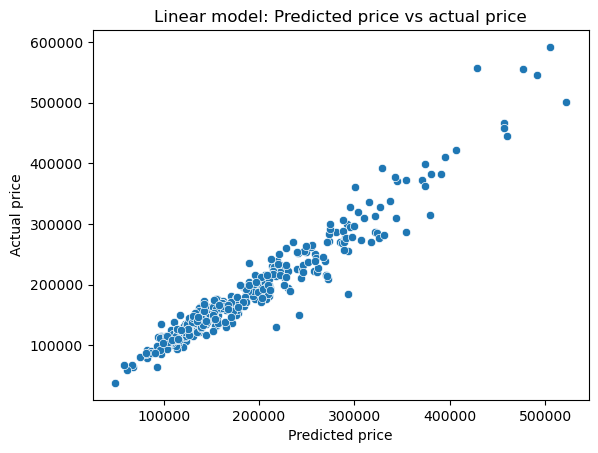

In [292]:
sns.scatterplot(x=y_linear.squeeze(), y=y_test_no_drop.squeeze())
plt.title("Linear model: Predicted price vs actual price")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.savefig("../images/linear_model.png");

In [293]:
print(f"Train RMSE: {linear_train_rmse}")
print(f"Test RMSE: {linear_test_rmse}")
print(f"Test no drop RMSE: {linear_test_no_drop_rmse}")

Train RMSE: 16563.866018989404
Test RMSE: 22296.047249553034
Test no drop RMSE: 21382.554820489306


In [294]:
print(f"Train r^2: {linear_train_r2}")
print(f"Test r^2: {linear_test_r2}")
print(f"Test no drop r^2: {linear_test_no_drop_r2}")

Train r^2: 0.9515833835720482
Test r^2: 0.9078900166291696
Test no drop r^2: 0.9339105547449773


The linear model does not look like a good choice.

### Ridge model

In [295]:
y_ridge = ridge_estimator.predict(X_test_no_drop)

In [296]:
sns.scatterplot(x=y_ridge.squeeze(), y=y_test_no_drop.squeeze())
plt.title("Ridge model: Predicted price vs actual price")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.savefig("../images/ridge_model.png");

In [297]:
print(f"Train RMSE: {ridge_train_rmse}")
print(f"Test RMSE: {ridge_test_rmse}")
print(f"Test no drop RMSE: {ridge_test_no_drop_rmse}")

Train RMSE: -21087.714177587157
Test RMSE: 22582.80102331542
Test no drop RMSE: 21569.66009762406


In [298]:
print(f"Train r^2: {ridge_train_r2}")
print(f"Test r^2: {ridge_test_r2}")
print(f"Test no drop r^2: {ridge_test_no_drop_r2}")

Train r^2: 0.9394721600443844
Test r^2: 0.9055054920856633
Test no drop r^2: 0.9327488800777015


The ridge model looks like a better option than the linear model.

### Polynomial linear model

In [299]:
y_polynomial_linear = polynomial_linear_estimator.predict(X_test_no_drop)

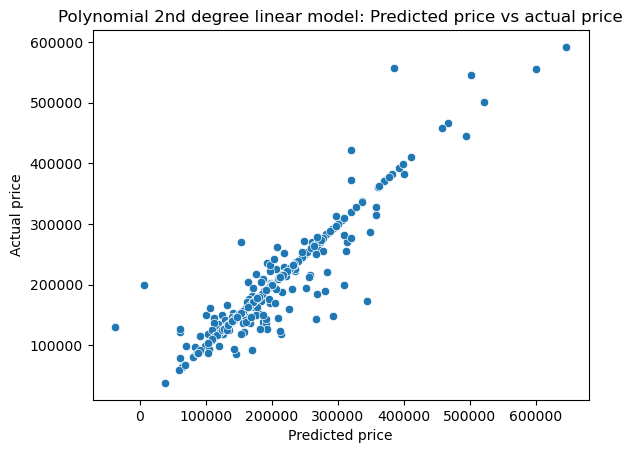

In [300]:
sns.scatterplot(x=y_polynomial_linear.squeeze(), y=y_test_no_drop.squeeze())
plt.title("Polynomial 2nd degree linear model: Predicted price vs actual price")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.savefig("../images/polynomial_2nd_degree_linear_model.png");

In [301]:
print(f"Train RMSE: {polynomial_linear_train_rmse}")
print(f"Test RMSE: {polynomial_linear_test_rmse}")
print(f"Test no drop RMSE: {polynomial_linear_test_no_drop_rmse}")

Train RMSE: -33696.268126162446
Test RMSE: 39100.203601617606
Test no drop RMSE: 68133.23459516643


In [302]:
print(f"Train r^2: {polynomial_linear_train_r2}")
print(f"Test r^2: {polynomial_linear_test_r2}")
print(f"Test no drop r^2: {polynomial_linear_test_no_drop_r2}")

Train r^2: 1.0
Test r^2: 0.7167245165015956
Test no drop r^2: 0.8670336076470314


The polynomial 2nd degree linear model is clearly overfit.

### Polynomial 2nd degree ridge model

In [303]:
y_polynomial_ridge = polynomial_ridge_estimator.predict(X_test_no_drop)

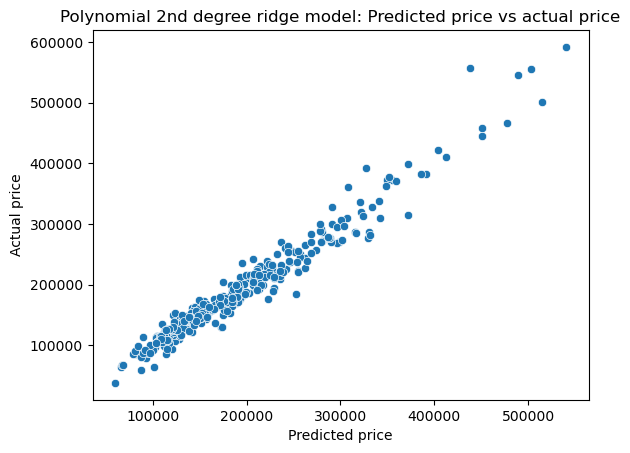

In [304]:
sns.scatterplot(x=y_polynomial_ridge.squeeze(), y=y_test_no_drop.squeeze())
plt.title("Polynomial 2nd degree ridge model: Predicted price vs actual price")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.savefig("../images/polynomial_2nd_degree_ridge_model.png");

In [305]:
print(f"Train RMSE: {polynomial_ridge_train_rmse}")
print(f"Test RMSE: {polynomial_ridge_test_rmse}")
print(f"Test no drop RMSE: {polynomial_ridge_test_no_drop_rmse}")

Train RMSE: -19458.050334926404
Test RMSE: 20450.20896528125
Test no drop RMSE: 17092.9126508788


In [306]:
print(f"Train r^2: {polynomial_ridge_train_r2}")
print(f"Test r^2: {polynomial_ridge_test_r2}")
print(f"Test no drop r^2: {polynomial_ridge_test_no_drop_r2}")

Train r^2: 0.9651640449907648
Test r^2: 0.9225098588502334
Test no drop r^2: 0.9577676678410817


The polynomial 2nd degree ridge model looks best.

### The best model

While the polynomial 2nd degree ridge model has some flaws--its train and test RMSE and $r^2$ scores are very similar, but very different from the train without drop scores--it is, to the eye and in RMSE terms, the best model we have.
<br>
We ran our model on the `test.cv` dataset and scored 19313.92988 in RMSE. This means that, in average, our housing price predictions will be off by about $19314.

## Saving the predictions

As part of the challenge, we save and submit our predictions to Kaggle.

In [307]:
housing_test = pd.read_csv("../data/test.csv")
polynomial_ridge_estimator.fit(X_train_no_drop, y_train_no_drop)
df = pd.DataFrame(polynomial_ridge_estimator.predict(housing_test), index=housing_test["Unnamed: 0"])
df.columns = ["SalePrice"]
df.to_csv("../data/4sd + log + ridge + 2poly.csv")

## Interpreting the model

### Intercept interpretation

In [308]:
polynomial_ridge_estimator.named_steps["ridge_regressor"].intercept_[0]

82147.06935374743

In our model, the intercept is composed by numeric situations--perhaps all houses in the training set have at least one bathroom--and these ordinal situations:

* MS Zoning_A (agr)
* Street_Grvl
* Alley_Grvl
* Alley_0
* Land Contour_Low
* Lot Config_FR3
* Neighborhood_Blmngtn
* Condition 1_RRAe
* Condition 2_RRAe
* Bldg Type_Twnhs
* House Style_SLvl
* Roof Style_Shed
* Roof Matl_WdShngl
* Exterior 1st_AsbShng
* Exterior 2nd_AsbShng
* Mas Vnr Type_0
* Foundation_Wood
* Heating_Wall
* Central Air_N
* Garage Type_0
* Misc Feature_0
* Sale Type_Oth

Where the parameter is to the left of the underscore and the specific situation is to the right. As previously mentioned, when hot encoding, we use `"0"` to denote the lack of something, like `Alley_0` denotes the lack of access to an alley.
<br>
These specific situations are part of the intercept because they were dropped during the one hot encoding process, to avoid multicollinearity.

### Coefficients interpretation

In [309]:
len(polynomial_ridge_estimator.named_steps["ridge_regressor"].coef_[0])

30381

Note how our polynomial 2nd degree ridge model has about 30 thousand coefficients. This does not help interpretability, so to get some insights it may be best to conduct another correlation analysis on `train.csv`, this time on the features that matter the most to `SalePrice`.

In [310]:
for col in correlation_matrix.columns:
    if col != "SalePrice" and abs(correlation_matrix["SalePrice"][col]) > 0.6:
        to_drop.append(col)
        print((col, round(correlation_matrix['SalePrice'][col], 3)))

('Overall Qual', 0.796)
('Total Bsmt SF', 0.613)
('1st Flr SF', 0.6)
('Gr Liv Area', 0.692)
('Garage Cars', 0.649)
('Garage Area', 0.643)


It looks like `Overall Qual` is the most important factor affecting the price of a house.
<br>
`Total Bsmt SF` is also important, implying that the existence of a basement affects pricing.
<br>
Spacious first floors and living areas area also sought-after features.
<br>
And garage cars and area--highly correlated--also have a significant impact on the price of a property.

## Conclusion

All in all, our polynomial 2nd degree ridge model looks promising. As previously mentioned, we did not have enough computational capacity to explore higher polynomial degrees--notice our coefficents are already at ~30k--and we used `log1p` normalization even though `PowerTransformer()` objects performed better in our testing dataset, as this situation flip-flopped in the test dataset case.
<br>
Our model took certain assumptions, such as considering `Overall Qual` but not `Overall Cond`, due to their high and low correlation, respectively. And on multicollinearity, our model benefitted from dropping `Garage Yr Blt`, even though it had a high correlation with `SalePrice`, as the nature of the feature--year 0 if no garage--created modeling conflicts.
<br>
Finally, it is worth mentioning that we assessed using non-monolithic modeling techniques, such as having one pipeline for houses with garages and another for houses without garages, but, in the interest of time, we resorted to using a monolothic approach.

## References

[1] J. O, M. Harris, "Ames Iowa Submission". 2024. https://kaggle.com/competitions/adobe-dsb-34.